# Predicción de sitios CPG relevantes para predicción de cáncer de mama


## Importación de librerias relevantes

In [ ]:
!pip install gdown
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib. pyplot as plt


Definiendo archivos relevantes con los que se trabajo durante todo el proyecto


In [ ]:
def download_files_from_gd(files_dict):
  '''
  - files_dict: Diccionario en formato {filename_1: drive_id_1, ...., filename_n:drive_id_n}
  '''
  drive_prefix = "https://drive.google.com/uc?id="
  for file in files_dict:
    gdown.download(f"{drive_prefix}{files_dict[file]}", file)


In [ ]:
files = {
         'data_gdc.csv':'1S8drqgJSejzeJaE3OnbRoue50A7SZ0sw'
         }
download_files_from_gd(files)

Downloading...
From: https://drive.google.com/uc?id=1S8drqgJSejzeJaE3OnbRoue50A7SZ0sw
To: /content/data_gdc.csv
100%|██████████| 158M/158M [00:00<00:00, 159MB/s]


El dataset relevante a usar fue el de TCGA-BRCA con 27k sitios o islas cpg (metilaciones) debido a las siguientes razones:


*   Compatibilidad con el estado del arte: Pudimos notar que casi la totalidad de papers trabajaban con este proyecto
*   Introducción de sesgos al mesclar proyectos: Cada proyecto cuenta con diferentes técnicas de secuenciación de ADN, etnia o raza objetivo y tipo de tejido (sanguíneo o tejido mamario) de donde se extrae la muestra, esto imposibilita la mescla de proyectos con el fin de aplicar oversampling a las muestras minoritarias que para el proyecto TCGA-BRCA son las muestras con tumor.



In [ ]:
df_27k_tgc = pd.read_csv('data_gdc.csv', sep='\t')
df_27k_tgc = df_27k_tgc.drop(df_27k_tgc.columns[0], axis=1)

## Preprocesamiento de data

In [ ]:
df_27k_tgc['tumor'] = df_27k_tgc['sample_type'].apply(lambda x: 0 if x == 'Solid Tissue Normal' else 1)

In [ ]:
df_27k_tgc.head(5)

,cg22501393,cg18895155,cg27126442,cg15264255,cg18464559,cg20379125,cg20226593,cg12790134,cg07697569,cg13613532,...,cg26848248,cg09906309,file_id,size,disease,sample_type,age,race,etnia,tumor
0,0.028667,0.012232,0.075894,0.142088,0.016443,0.015846,0.856759,0.117437,0.041592,0.024423,...,0.022962,0.024748,fc6a1b6d-894e-4da5-be37-2b0b76770ab1,769178,Ductal and Lobular Neoplasms,Primary Tumor,28974.0,white,not hispanic or latino,1
1,0.029441,0.014666,0.105215,0.106937,0.017454,0.016934,NaN,0.012831,0.018839,0.011539,...,0.021182,0.028579,d42a557d-a77d-4f6b-8fb9-b5b6f4b3ea87,771468,Ductal and Lobular Neoplasms,Primary Tumor,20152.0,white,not hispanic or latino,1
2,0.034916,0.018333,0.363821,0.113594,0.016953,0.018574,0.861028,0.017720,0.019870,0.024152,...,0.020363,0.029775,04e87399-3399-4fd9-93a0-7b8b4953c0c7,774870,Ductal and Lobular Neoplasms,Primary Tumor,25259.0,white,not reported,1
3,0.025584,0.014079,0.232832,0.065338,0.018666,0.147531,NaN,0.109610,0.018852,0.021281,...,0.045688,0.056429,47d4e8b4-c92b-4e06-a436-9fdc419ff70b,761724,Ductal and Lobular Neoplasms,Primary Tumor,19836.0,white,not hispanic or latino,1
4,0.027670,0.015868,0.111733,0.071436,0.021284,0.014400,NaN,0.013111,0.019075,0.029269,...,0.021215,0.025321,f947716e-8978-4e56-9a70-243b330c8e51,770436,Ductal and Lobular Neoplasms,Primary Tumor,23742.0,not reported,not reported,1


In [ ]:
df_27k_tgc = df_27k_tgc.dropna(subset = ['age'])
df_27k_tgc = df_27k_tgc.dropna(axis=1)
df_27k_tgc = df_27k_tgc[df_27k_tgc['sample_type']!="Metastatic"]

In [ ]:
# Contar los valores de tumor
tumor_counts = df_27k_tgc['tumor'].value_counts()

# Imprimir el balance
print("Balance de tumor:")
tumor_counts

Balance de tumor:


1    312
0     27
Name: tumor, dtype: int64

In [ ]:
# Eliminar las columnas especificadas
df_27k_tgc = df_27k_tgc.drop(["file_id", "size", "disease", "sample_type"], axis=1)

In [ ]:
df_27k_tgc['tumor'] = df_27k_tgc['tumor'].astype(int)

In [ ]:
#Convirtiendo Age a años
df_27k_tgc['age'] = df_27k_tgc['age']/(365.25)

In [ ]:
df_27k_tgc.head(5)

,cg22501393,cg18895155,cg15264255,cg18464559,cg20379125,cg12790134,cg07697569,cg13613532,cg13951948,cg06590533,...,cg11500797,cg23348028,cg20880234,cg10265786,cg26848248,cg09906309,age,race,etnia,tumor
0,0.028667,0.012232,0.142088,0.016443,0.015846,0.117437,0.041592,0.024423,0.008772,0.014977,...,0.435940,0.029233,0.013970,0.010114,0.022962,0.024748,79.326489,white,not hispanic or latino,1
1,0.029441,0.014666,0.106937,0.017454,0.016934,0.012831,0.018839,0.011539,0.010769,0.015953,...,0.041898,0.016999,0.023700,0.010052,0.021182,0.028579,55.173169,white,not hispanic or latino,1
2,0.034916,0.018333,0.113594,0.016953,0.018574,0.017720,0.019870,0.024152,0.008728,0.018683,...,0.663796,0.024611,0.022013,0.010444,0.020363,0.029775,69.155373,white,not reported,1
3,0.025584,0.014079,0.065338,0.018666,0.147531,0.109610,0.018852,0.021281,0.005948,0.014338,...,0.098572,0.013955,0.011229,0.010144,0.045688,0.056429,54.308008,white,not hispanic or latino,1
4,0.027670,0.015868,0.071436,0.021284,0.014400,0.013111,0.019075,0.029269,0.011906,0.014320,...,0.858382,0.013347,0.016935,0.009704,0.021215,0.025321,65.002053,not reported,not reported,1


## Metadata de muestras

In [ ]:
# Obtener manifiesto de maquina Illumina 450k
url = 'https://webdata.illumina.com/downloads/productfiles/humanmethylation450/humanmethylation450_15017482_v1-2.csv'
url_27k = "https://support.illumina.com/content/dam/illumina-support/documents/downloads/productfiles/humanmethylation27/productsupportfiles/illumina_humanmethylation27_content.xlsx"
manifest = pd.read_csv(url, skiprows = 7)
manifest.head()

<ipython-input-187-79afb0a2cbe6>:4: DtypeWarning: Columns (2,4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  manifest = pd.read_csv(url, skiprows = 7)


,IlmnID,Name,AddressA_ID,AlleleA_ProbeSeq,AddressB_ID,AlleleB_ProbeSeq,Infinium_Design_Type,Next_Base,Color_Channel,Forward_Sequence,...,UCSC_RefGene_Group,UCSC_CpG_Islands_Name,Relation_to_UCSC_CpG_Island,Phantom,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS
0,cg00035864,cg00035864,31729416,AAAACACTAACAATCTTATCCACATAAACCCTTAAATTTATCTCAA...,NaN,NaN,II,NaN,NaN,AATCCAAAGATGATGGAGGAGTGCCCGCTCATGATGTGAAGTACCT...,...,TSS1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cg00050873,cg00050873,32735311,ACAAAAAAACAACACACAACTATAATAATTTTTAAAATAAATAAAC...,31717405.0,ACGAAAAAACAACGCACAACTATAATAATTTTTAAAATAAATAAAC...,I,A,Red,TATCTCTGTCTGGCGAGGAGGCAACGCACAACTGTGGTGGTTTTTG...,...,Body;TSS1500,chrY:9363680-9363943,N_Shore,NaN,NaN,NaN,Y:9973136-9976273,NaN,NaN,NaN
2,cg00061679,cg00061679,28780415,AAAACATTAAAAAACTAATTCACTACTATTTAATTACTTTATTTTC...,NaN,NaN,II,NaN,NaN,TCAACAAATGAGAGACATTGAAGAACTAATTCACTACTATTTGGTT...,...,Body;Body;Body,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cg00063477,cg00063477,16712347,TATTCTTCCACACAAAATACTAAACRTATATTTACAAAAATACTTC...,NaN,NaN,II,NaN,NaN,CTCCTGTACTTGTTCATTAAATAATGATTCCTTGGATATACCAAGT...,...,Body,chrY:22737825-22738052,S_Shelf,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,cg00121626,cg00121626,19779393,AAAACTAATAAAAATAACTTACAAACCAAATACTATACCCTACAAC...,NaN,NaN,II,NaN,NaN,AGGTGAATGAAGAGACTAATGGGAGTGGCTTGCAAGCCAGGTACTG...,...,Body,chrY:21664481-21665063,N_Shore,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
features_genes = manifest[manifest.IlmnID.isin(df_27k_tgc)]
features_genes.columns

Index(['IlmnID', 'Name', 'AddressA_ID', 'AlleleA_ProbeSeq', 'AddressB_ID',
       'AlleleB_ProbeSeq', 'Infinium_Design_Type', 'Next_Base',
       'Color_Channel', 'Forward_Sequence', 'Genome_Build', 'CHR', 'MAPINFO',
       'SourceSeq', 'Chromosome_36', 'Coordinate_36', 'Strand', 'Probe_SNPs',
       'Probe_SNPs_10', 'Random_Loci', 'Methyl27_Loci', 'UCSC_RefGene_Name',
       'UCSC_RefGene_Accession', 'UCSC_RefGene_Group', 'UCSC_CpG_Islands_Name',
       'Relation_to_UCSC_CpG_Island', 'Phantom', 'DMR', 'Enhancer',
       'HMM_Island', 'Regulatory_Feature_Name', 'Regulatory_Feature_Group',
       'DHS'],
      dtype='object')

In [ ]:
common_genes = features_genes['UCSC_RefGene_Name'].value_counts()
common_genes

ALX4                                            18
CHFR;CHFR;CHFR;CHFR;CHFR                        16
WT1;WT1;WT1;WT1                                 15
MGMT                                            14
GATA4                                           13
                                                ..
COX7A2;COX7A2                                    1
CTGF                                             1
KATNA1                                           1
C6orf203;C6orf203;C6orf203;C6orf203;C6orf203     1
PDXP                                             1
Name: UCSC_RefGene_Name, Length: 12901, dtype: int64

In [ ]:
# Convertir la serie en un dataframe
common_genes_df = common_genes.to_frame()

# Mostrar el dataframe resultante
common_genes_df.head(5)

,UCSC_RefGene_Name
ALX4,18
CHFR;CHFR;CHFR;CHFR;CHFR,16
WT1;WT1;WT1;WT1,15
MGMT,14
GATA4,13


In [ ]:
common_genes_df.shape

(12901, 1)

In [ ]:
def get_gene_cpg(df, gene_name):
  gene_cpg = df[df['UCSC_RefGene_Name']==gene_name]['Name']
  return list(gene_cpg)

def get_cpg_met(df, cpg_list):
  df_gene = df[cpg_list]
  return df_gene

In [ ]:
wt1_cpg = get_gene_cpg(features_genes, 'WT1;WT1;WT1;WT1')
df_wt1 = get_cpg_met(df_27k_tgc, wt1_cpg)
df_wt1.head()

,cg04096767,cg04456238,cg05222924,cg06516124,cg12006284,cg13301003,cg13641903,cg15446391,cg16092786,cg16463460,cg16501028,cg22511262,cg22533573,cg25094569,cg25782229
0,0.129698,0.068865,0.090248,0.064562,0.049565,0.222730,0.234499,0.131987,0.219596,0.072714,0.220510,0.063500,0.421309,0.046962,0.120914
1,0.846622,0.865154,0.545220,0.759101,0.870496,0.829852,0.881656,0.817095,0.035522,0.792783,0.853771,0.649777,0.515467,0.659813,0.881298
2,0.641307,0.665426,0.137536,0.608641,0.502142,0.651961,0.753738,0.741489,0.478034,0.666920,0.568189,0.310123,0.483498,0.261227,0.708104
3,0.071127,0.706378,0.238629,0.056478,0.079252,0.090934,0.850720,0.232569,0.202788,0.293138,0.236416,0.135601,0.123210,0.063288,0.326457
4,0.790159,0.797333,0.781131,0.684165,0.831692,0.823477,0.820845,0.793799,0.676181,0.818460,0.813134,0.620241,0.691530,0.793512,0.915175


In [ ]:
# Obtener las columnas de df_wt1
columnas_df_wt1 = df_wt1.columns

# Seleccionar las columnas en df_27k_tgc que están en df_wt1
df_27k_tgc_wt1 = df_27k_tgc.loc[:, columnas_df_wt1]

# Agregar las columnas "age", "race", "etnia" y "tumor" a df_27k_tgc_filtrado
df_27k_tgc_wt1 = pd.concat([df_27k_tgc_wt1, df_27k_tgc[['age', 'race', 'etnia', 'tumor']]], axis=1)

# Crear los rangos de edad
rango_edad = pd.cut(df_27k_tgc_wt1['age'], bins=range(0, 101, 10), right=False)

# Asignar niveles a cada rango de edad
niveles_edad, _ = pd.factorize(rango_edad, sort=True)

# Agregar la columna de niveles de edad al DataFrame original
df_27k_tgc_wt1['Nivel Edad'] = niveles_edad + 1

# Verificar el nuevo DataFrame filtrado
df_27k_tgc_wt1.head(5)


,cg04096767,cg04456238,cg05222924,cg06516124,cg12006284,cg13301003,cg13641903,cg15446391,cg16092786,cg16463460,cg16501028,cg22511262,cg22533573,cg25094569,cg25782229,age,race,etnia,tumor,Nivel Edad
0,0.129698,0.068865,0.090248,0.064562,0.049565,0.222730,0.234499,0.131987,0.219596,0.072714,0.220510,0.063500,0.421309,0.046962,0.120914,79.326489,white,not hispanic or latino,1,6
1,0.846622,0.865154,0.545220,0.759101,0.870496,0.829852,0.881656,0.817095,0.035522,0.792783,0.853771,0.649777,0.515467,0.659813,0.881298,55.173169,white,not hispanic or latino,1,4
2,0.641307,0.665426,0.137536,0.608641,0.502142,0.651961,0.753738,0.741489,0.478034,0.666920,0.568189,0.310123,0.483498,0.261227,0.708104,69.155373,white,not reported,1,5
3,0.071127,0.706378,0.238629,0.056478,0.079252,0.090934,0.850720,0.232569,0.202788,0.293138,0.236416,0.135601,0.123210,0.063288,0.326457,54.308008,white,not hispanic or latino,1,4
4,0.790159,0.797333,0.781131,0.684165,0.831692,0.823477,0.820845,0.793799,0.676181,0.818460,0.813134,0.620241,0.691530,0.793512,0.915175,65.002053,not reported,not reported,1,5


## EDA de Top 4 genes con mayor sitios CPG

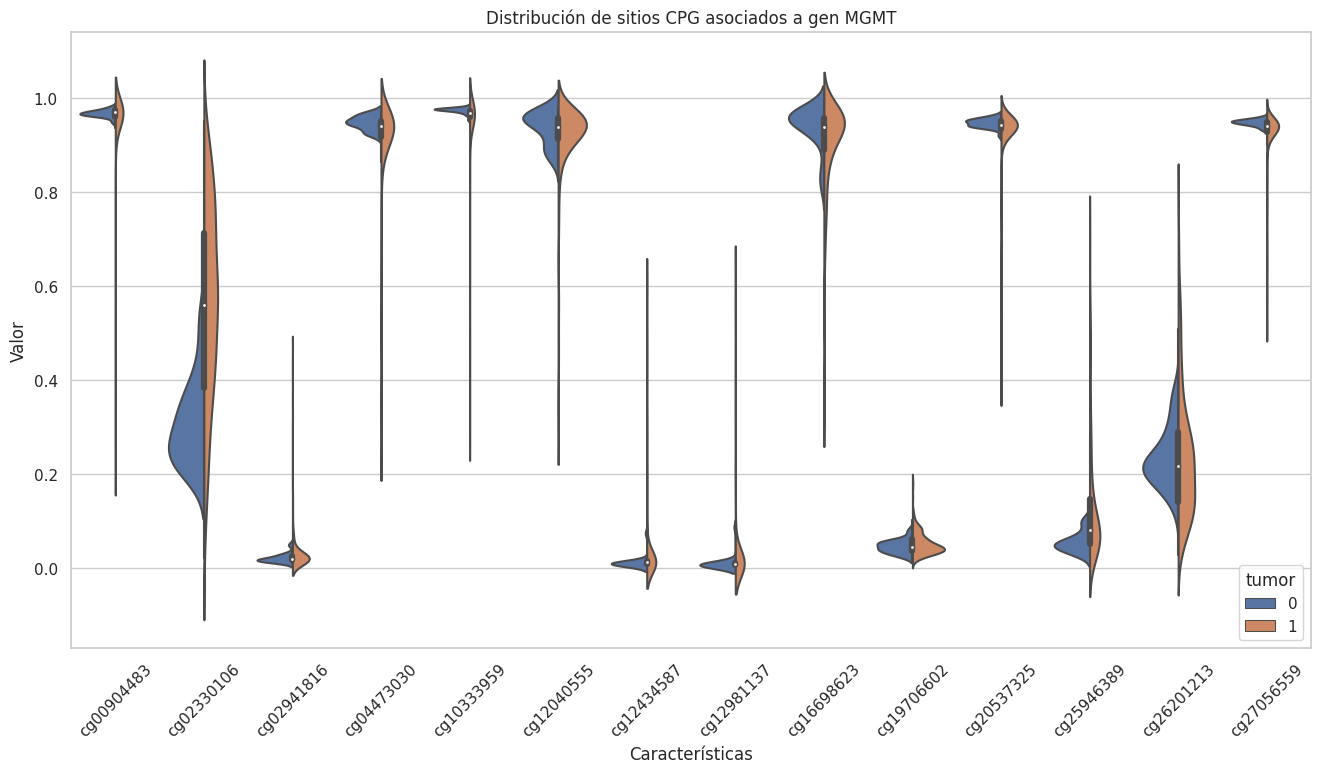

In [ ]:
MGMT_cpg = get_gene_cpg(features_genes, 'MGMT')
df_MGMT = get_cpg_met(df_27k_tgc, MGMT_cpg)
# Obtener las columnas de df_wt1
columnas_df_MGMT = df_MGMT.columns

# Seleccionar las columnas en df_27k_tgc que están en df_wt1
df_27k_tgc_MGMT = df_27k_tgc.loc[:, columnas_df_MGMT]

# Agregar las columnas "age", "race", "etnia" y "tumor" a df_27k_tgc_filtrado
df_27k_tgc_MGMT = pd.concat([df_27k_tgc_MGMT, df_27k_tgc[['age', 'race', 'etnia', 'tumor']]], axis=1)

# Crear un DataFrame solo con las características seleccionadas y la clase 'tumor'
data = df_27k_tgc_MGMT.drop(['race', 'etnia', 'age'], axis=1)

# Convertir los datos al formato largo (long format) para la visualización de violín
data_melted = data.melt(id_vars='tumor', var_name='Feature', value_name='Value')

# Crear la visualización de violín utilizando seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))
sns.violinplot(x='Feature', y='Value', hue='tumor', data=data_melted, split=True)
plt.xticks(rotation=45)
plt.title("Distribución de sitios CPG asociados a gen MGMT")
plt.xlabel("Características")
plt.ylabel("Valor")
plt.show()

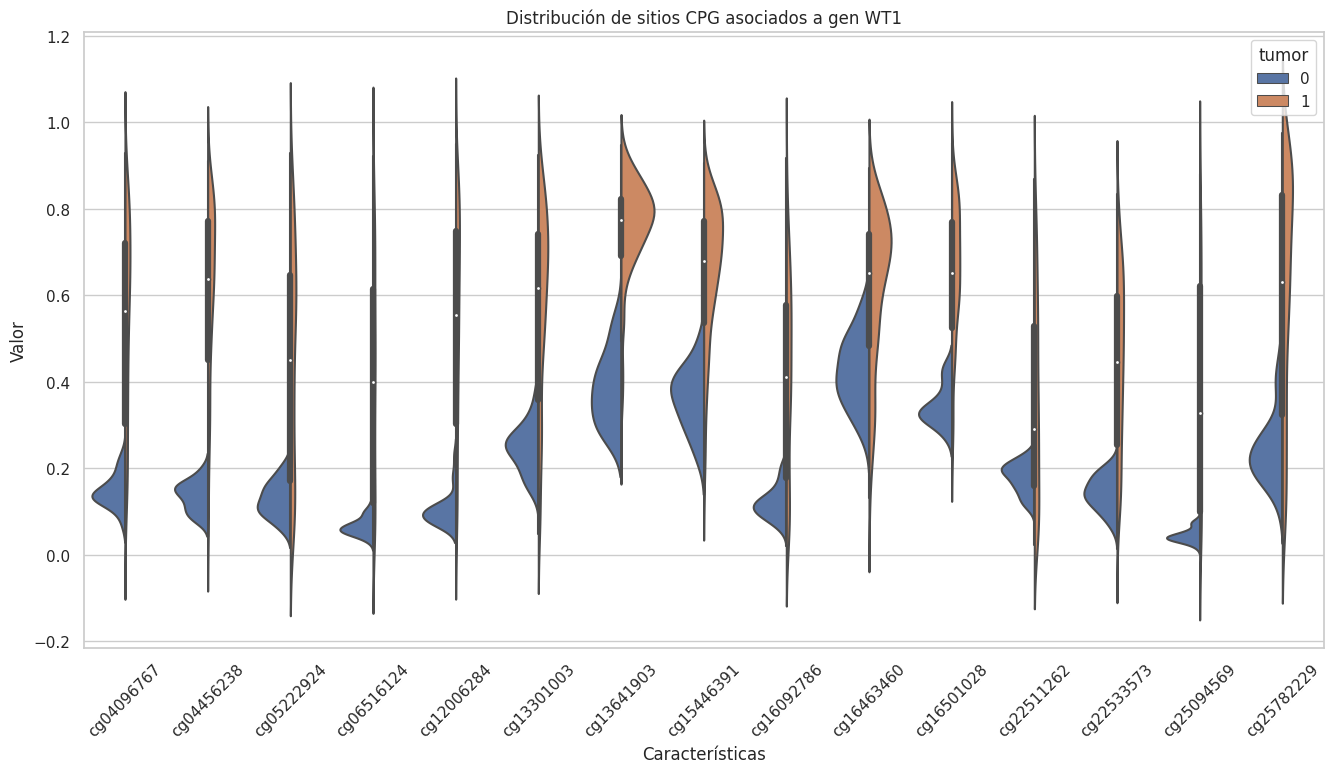

In [ ]:
# Crear un DataFrame solo con las características seleccionadas y la clase 'tumor'
data = df_27k_tgc_wt1.drop(['race', 'etnia', 'age', 'Nivel Edad'], axis=1)

# Convertir los datos al formato largo (long format) para la visualización de violín
data_melted = data.melt(id_vars='tumor', var_name='Feature', value_name='Value')

# Crear la visualización de violín utilizando seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))
sns.violinplot(x='Feature', y='Value', hue='tumor', data=data_melted, split=True)
plt.xticks(rotation=45)
plt.title("Distribución de sitios CPG asociados a gen WT1")
plt.xlabel("Características")
plt.ylabel("Valor")
plt.show()

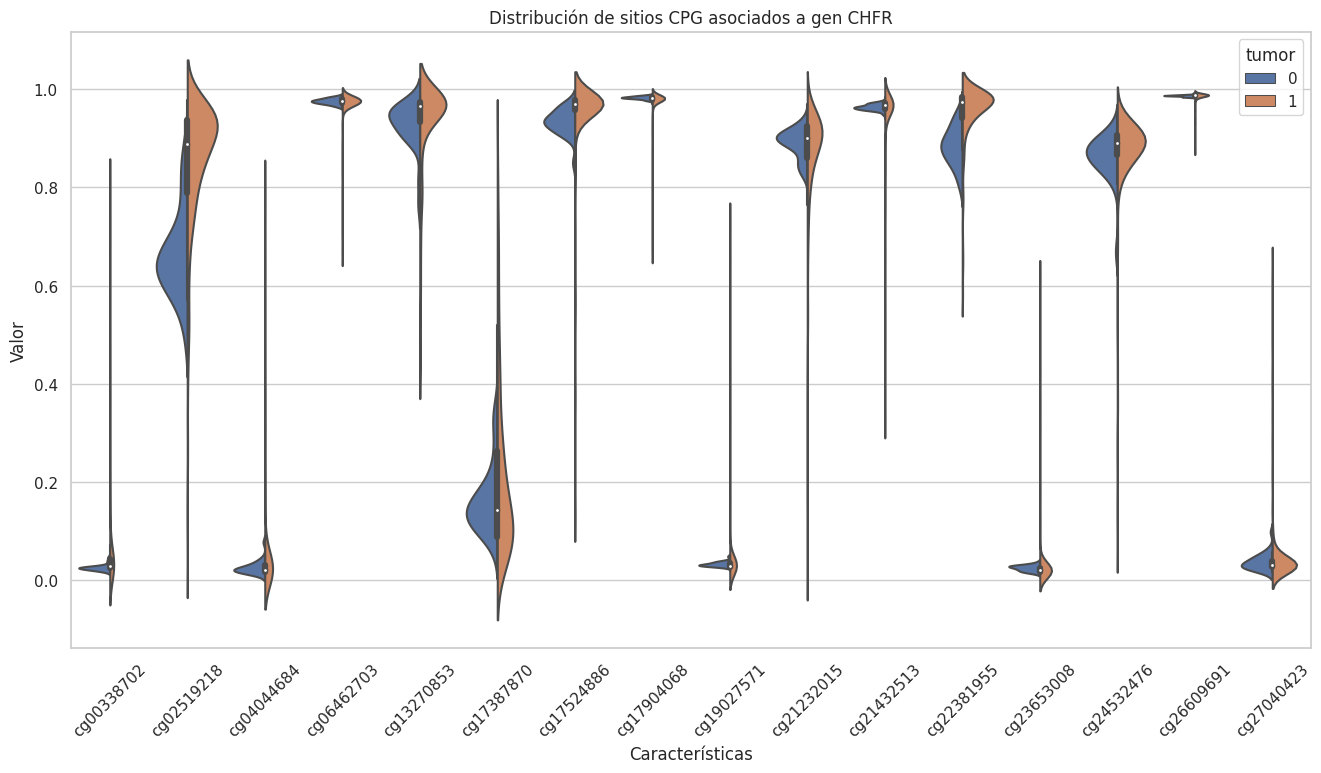

In [ ]:
CHFR_cpg = get_gene_cpg(features_genes, 'CHFR;CHFR;CHFR;CHFR;CHFR')
df_CHFR = get_cpg_met(df_27k_tgc, CHFR_cpg)
# Obtener las columnas de df_wt1
columnas_df_CHFR = df_CHFR.columns

# Seleccionar las columnas en df_27k_tgc que están en df_wt1
df_27k_tgc_CHFR = df_27k_tgc.loc[:, columnas_df_CHFR]

# Agregar las columnas "age", "race", "etnia" y "tumor" a df_27k_tgc_filtrado
df_27k_tgc_CHFR = pd.concat([df_27k_tgc_CHFR, df_27k_tgc[['age', 'race', 'etnia', 'tumor']]], axis=1)

# Crear un DataFrame solo con las características seleccionadas y la clase 'tumor'
data = df_27k_tgc_CHFR.drop(['race', 'etnia', 'age'], axis=1)

# Convertir los datos al formato largo (long format) para la visualización de violín
data_melted = data.melt(id_vars='tumor', var_name='Feature', value_name='Value')

# Crear la visualización de violín utilizando seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))
sns.violinplot(x='Feature', y='Value', hue='tumor', data=data_melted, split=True)
plt.xticks(rotation=45)
plt.title("Distribución de sitios CPG asociados a gen CHFR")
plt.xlabel("Características")
plt.ylabel("Valor")
plt.show()

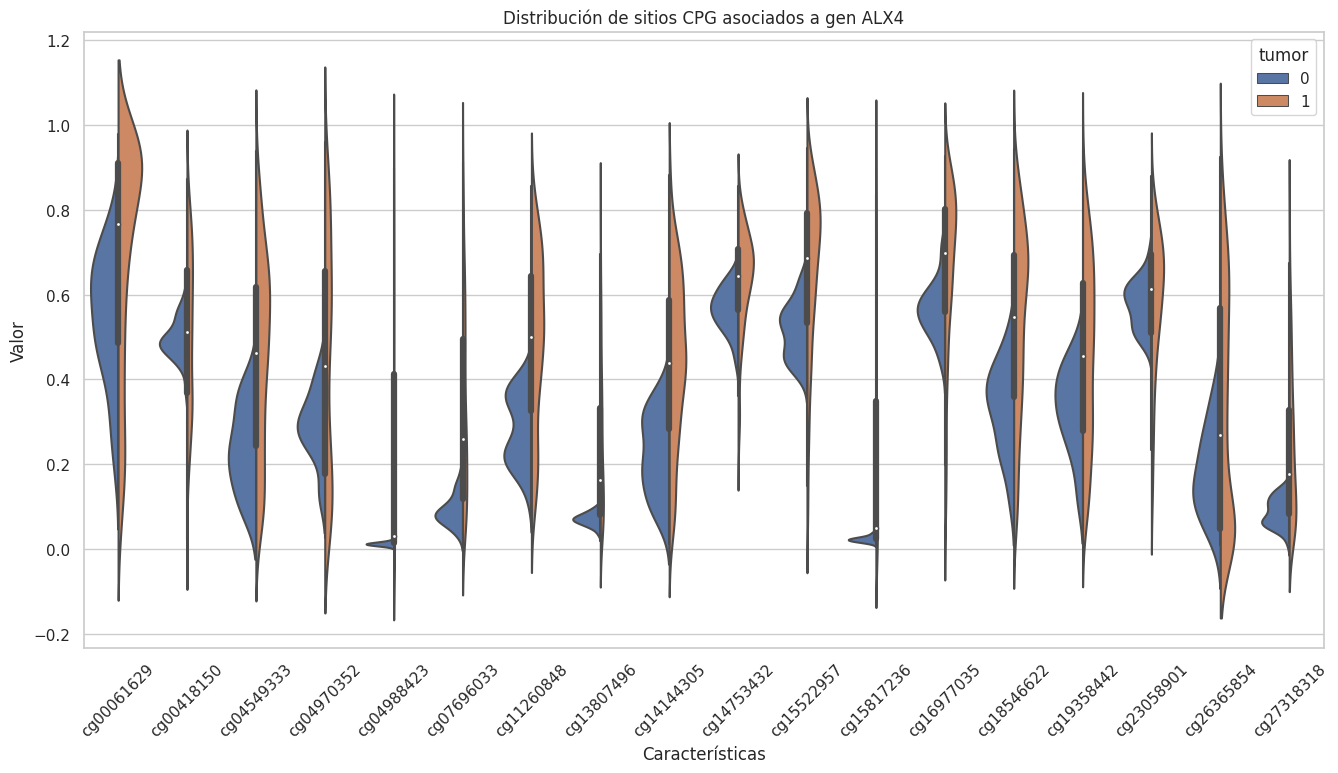

In [ ]:
ALX4_cpg = get_gene_cpg(features_genes, 'ALX4')
df_ALX4 = get_cpg_met(df_27k_tgc, ALX4_cpg)
# Obtener las columnas de df_wt1
columnas_df_ALX4 = df_ALX4.columns

# Seleccionar las columnas en df_27k_tgc que están en df_wt1
df_27k_tgc_ALX4 = df_27k_tgc.loc[:, columnas_df_ALX4]

# Agregar las columnas "age", "race", "etnia" y "tumor" a df_27k_tgc_filtrado
df_27k_tgc_ALX4 = pd.concat([df_27k_tgc_ALX4, df_27k_tgc[['age', 'race', 'etnia', 'tumor']]], axis=1)

# Crear un DataFrame solo con las características seleccionadas y la clase 'tumor'
data = df_27k_tgc_ALX4.drop(['race', 'etnia', 'age'], axis=1)

# Convertir los datos al formato largo (long format) para la visualización de violín
data_melted = data.melt(id_vars='tumor', var_name='Feature', value_name='Value')

# Crear la visualización de violín utilizando seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))
sns.violinplot(x='Feature', y='Value', hue='tumor', data=data_melted, split=True)
plt.xticks(rotation=45)
plt.title("Distribución de sitios CPG asociados a gen ALX4")
plt.xlabel("Características")
plt.ylabel("Valor")
plt.show()

## EDA de Top 10 sitios CPG más correlacionados con clase tumor

In [ ]:
# Suponiendo que 'df_27k_tgc' es un DataFrame con las características y la clase 'tumor'

correlations = df_27k_tgc.corrwith(df_27k_tgc['tumor']).abs().sort_values(ascending=False)
top_10_features = correlations.index[1:11]



<ipython-input-199-f30868970cbe>:3: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df_27k_tgc.corrwith(df_27k_tgc['tumor']).abs().sort_values(ascending=False)


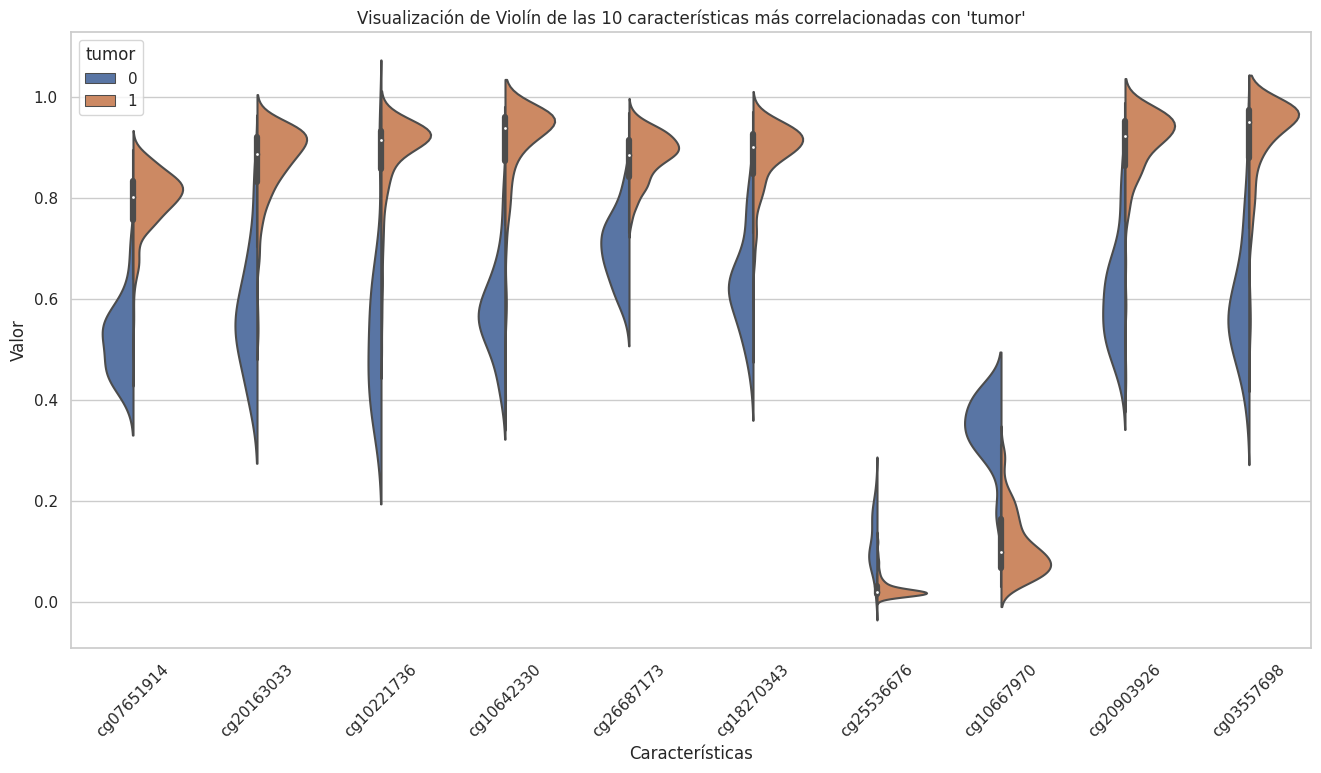

In [ ]:
# Crear un DataFrame solo con las características seleccionadas y la clase 'tumor'
data = df_27k_tgc[top_10_features.tolist() + ['tumor']]

# Convertir los datos al formato largo (long format) para la visualización de violín
data_melted = data.melt(id_vars='tumor', var_name='Feature', value_name='Value')

# Crear la visualización de violín utilizando seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))
sns.violinplot(x='Feature', y='Value', hue='tumor', data=data_melted, split=True)
plt.xticks(rotation=45)
plt.title("Visualización de Violín de las 10 características más correlacionadas con 'tumor'")
plt.xlabel("Características")
plt.ylabel("Valor")
plt.show()

## Reducción de dimensionalidad

Se uso distintos métodos de reducción de dimensionalidad basados en paper [Application of Feature Selection and Deep Learning for Cancer Prediction Using DNA Methylation Markers](https://pubmed.ncbi.nlm.nih.gov/36140725/)

In [ ]:
seed = 42 #Semilla para reproducibilidad

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import f_classif, SelectKBest, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, cohen_kappa_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Splitting data into features and target
X = df_27k_tgc.iloc[:, 0:len(df_27k_tgc.columns)-3].values
Y = df_27k_tgc.iloc[:, len(df_27k_tgc.columns)-1].values

In [ ]:
# Imprimir la distribución de las clases después del balanceo
print("Distribución de clases después del balanceo:")
print(pd.Series(Y).value_counts())

Distribución de clases después del balanceo:
1    312
0     27
dtype: int64


Número de features obtenidos por cada método:

In [ ]:
import torch
import random
import numpy as np
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)  # Establece la semilla para generación de números aleatorios en Torch
torch.cuda.manual_seed(42)  # Establece la semilla para generación de números aleatorios en CUDA (si se utiliza GPU)
torch.backends.cudnn.deterministic = True  # Establece la determinación de los algoritmos de CUDA para mayor reproducibilidad

print("Total number of features:", X.shape[1])
a = round(0.85 * X.shape[1])
print("85% of total feature: ", a)
X_new = SelectKBest(f_classif, k=a).fit_transform(X, Y)
fvals, pvals = f_classif(X_new, Y)
to_remove = pvals >= (0.05 / X_new.shape[1])
X_anova = np.delete(X_new, obj=to_remove, axis=1)
print("Number of selected features using ANOVA F-test:", X_anova.shape[1])

sel = SelectFromModel(RandomForestClassifier())
sel.fit(X, Y)
rf_sel_features = sel.get_support()
X_rf = np.delete(X, obj=~np.array(rf_sel_features), axis=1)
print("Number of selected features using RF:", X_rf.shape[1])

sel = SelectFromModel(RandomForestClassifier())
sel.fit(X_anova, Y)
anova_rf_sel_features = sel.get_support()
X_anova_rf = np.delete(X_anova, obj=~np.array(anova_rf_sel_features), axis=1)
print("Number of selected features using ANOVA and RF:", X_anova_rf.shape[1])

from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel

# Reduced features using XGBoost
sel = SelectFromModel(XGBClassifier())
sel.fit(X, Y)
xgb_sel_features = sel.get_support()
X_xgb = np.delete(X, obj=~np.array(xgb_sel_features), axis=1)
print("Number of selected features using XGBoost:", X_xgb.shape[1])

sel = SelectFromModel(XGBClassifier())
sel.fit(X_anova, Y)
anova_xgb_sel_features = sel.get_support()
X_anova_xgb = np.delete(X_anova, obj=~np.array(anova_xgb_sel_features), axis=1)
print("Number of selected features using ANOVA and XGBoost:", X_anova_xgb.shape[1])

Total number of features: 17270
85% of total feature:  14680
Number of selected features using ANOVA F-test: 3121
Number of selected features using RF: 399
Number of selected features using ANOVA and RF: 273
Number of selected features using XGBoost: 23
Number of selected features using ANOVA and XGBoost: 23


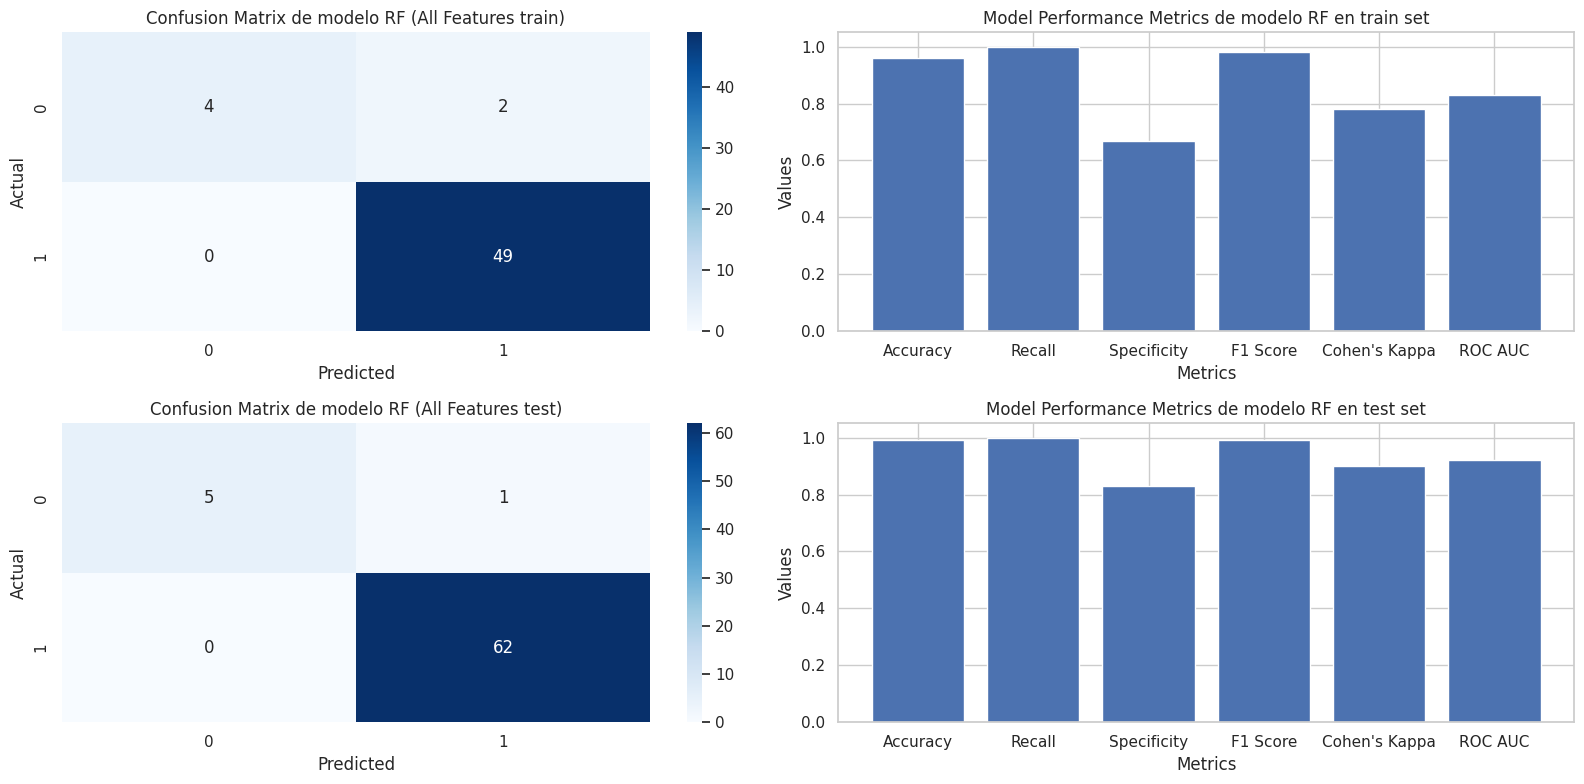

In [ ]:

# Train-test-validation split on total features (before feature selection)
X_train0, X_test, y_train0, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train0, y_train0, test_size=0.2, random_state=seed)

# Performance of Random forest model on total features
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
# Matriz de confusión
confusion = confusion_matrix(y_val, y_pred)

# Establecer tamaño de la figura
plt.figure(figsize=(16, 8))

# Heat map de la matriz de confusión
plt.subplot(2, 2, 1)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de modelo RF (All Features train)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_val, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_val, y_pred), 2)
roc_auc = round(roc_auc_score(y_val, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 2)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de modelo RF en train set")

y_pred = RF.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Heat map de la matriz de confusión
plt.subplot(2, 2, 3)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de modelo RF (All Features test)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_test, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_test, y_pred), 2)
roc_auc = round(roc_auc_score(y_test, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 4)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de modelo RF en test set")

# Mostrar los gráficos
plt.tight_layout()
plt.show()



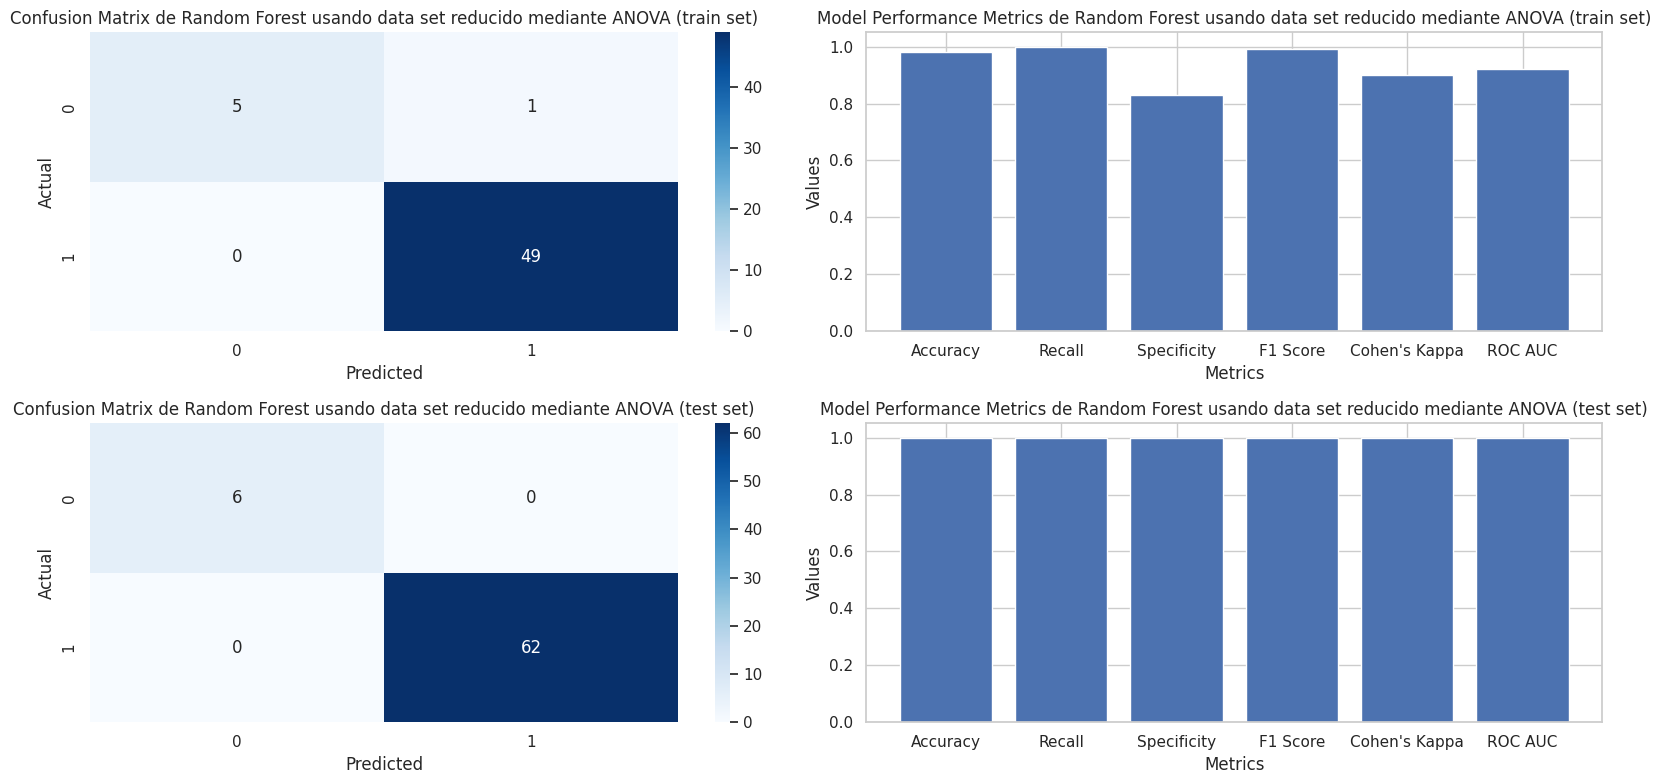

In [ ]:
# Train-test-validation split on reduced features (ANOVA)
X_train0, X_test, y_train0, y_test = train_test_split(X_anova, Y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train0, y_train0, test_size=0.2, random_state=seed)

# Performance of Random forest model on reduced features (ANOVA)
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

# Matriz de confusión
confusion = confusion_matrix(y_val, y_pred)


# Establecer tamaño de la figura
plt.figure(figsize=(16, 8))

# Heat map de la matriz de confusión
plt.subplot(2, 2, 1)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de Random Forest usando data set reducido mediante ANOVA (train set)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_val, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_val, y_pred), 2)
roc_auc = round(roc_auc_score(y_val, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 2)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de Random Forest usando data set reducido mediante ANOVA (train set)")

y_pred = RF.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Heat map de la matriz de confusión
plt.subplot(2, 2, 3)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de Random Forest usando data set reducido mediante ANOVA (test set)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_test, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_test, y_pred), 2)
roc_auc = round(roc_auc_score(y_test, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 4)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de Random Forest usando data set reducido mediante ANOVA (test set)")

# Mostrar los gráficos
plt.tight_layout()
plt.show()


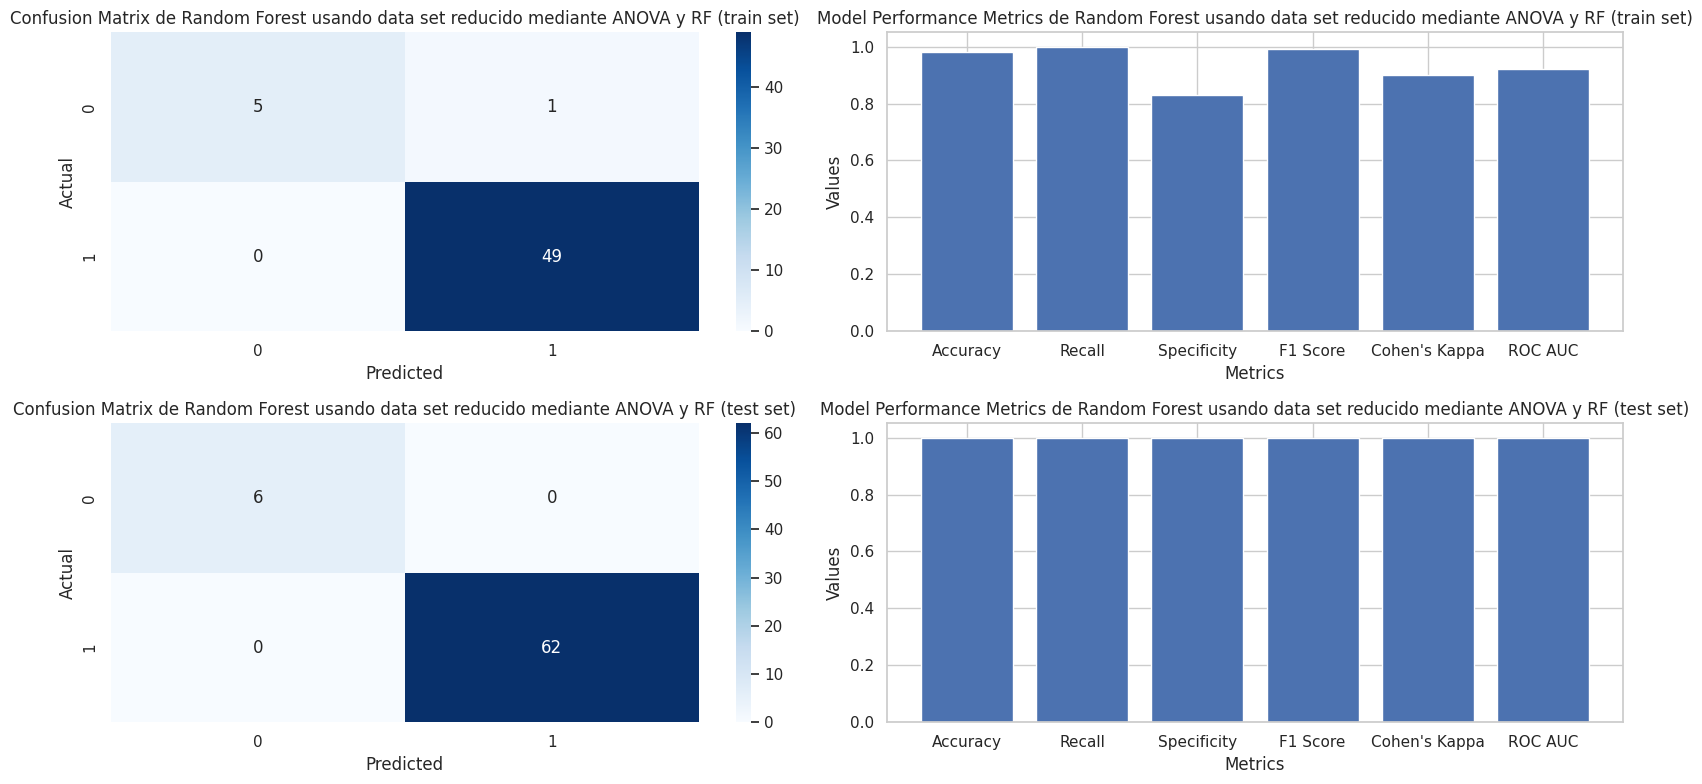

In [ ]:
# Train-test-validation split on reduced features (ANOVA + RF)
X_train0, X_test, y_train0, y_test = train_test_split(X_anova_rf, Y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train0, y_train0, test_size=0.2, random_state=seed)

# Performance of Random forest model on reduced features (ANOVA + RF)
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

# Matriz de confusión
confusion = confusion_matrix(y_val, y_pred)

# Establecer tamaño de la figura
plt.figure(figsize=(16, 8))

# Heat map de la matriz de confusión
plt.subplot(2, 2, 1)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de Random Forest usando data set reducido mediante ANOVA y RF (train set)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_val, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_val, y_pred), 2)
roc_auc = round(roc_auc_score(y_val, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 2)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de Random Forest usando data set reducido mediante ANOVA y RF (train set)")

y_pred = RF.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Heat map de la matriz de confusión
plt.subplot(2, 2, 3)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de Random Forest usando data set reducido mediante ANOVA y RF (test set)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_test, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_test, y_pred), 2)
roc_auc = round(roc_auc_score(y_test, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 4)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de Random Forest usando data set reducido mediante ANOVA y RF (test set)")

# Mostrar los gráficos
plt.tight_layout()
plt.show()

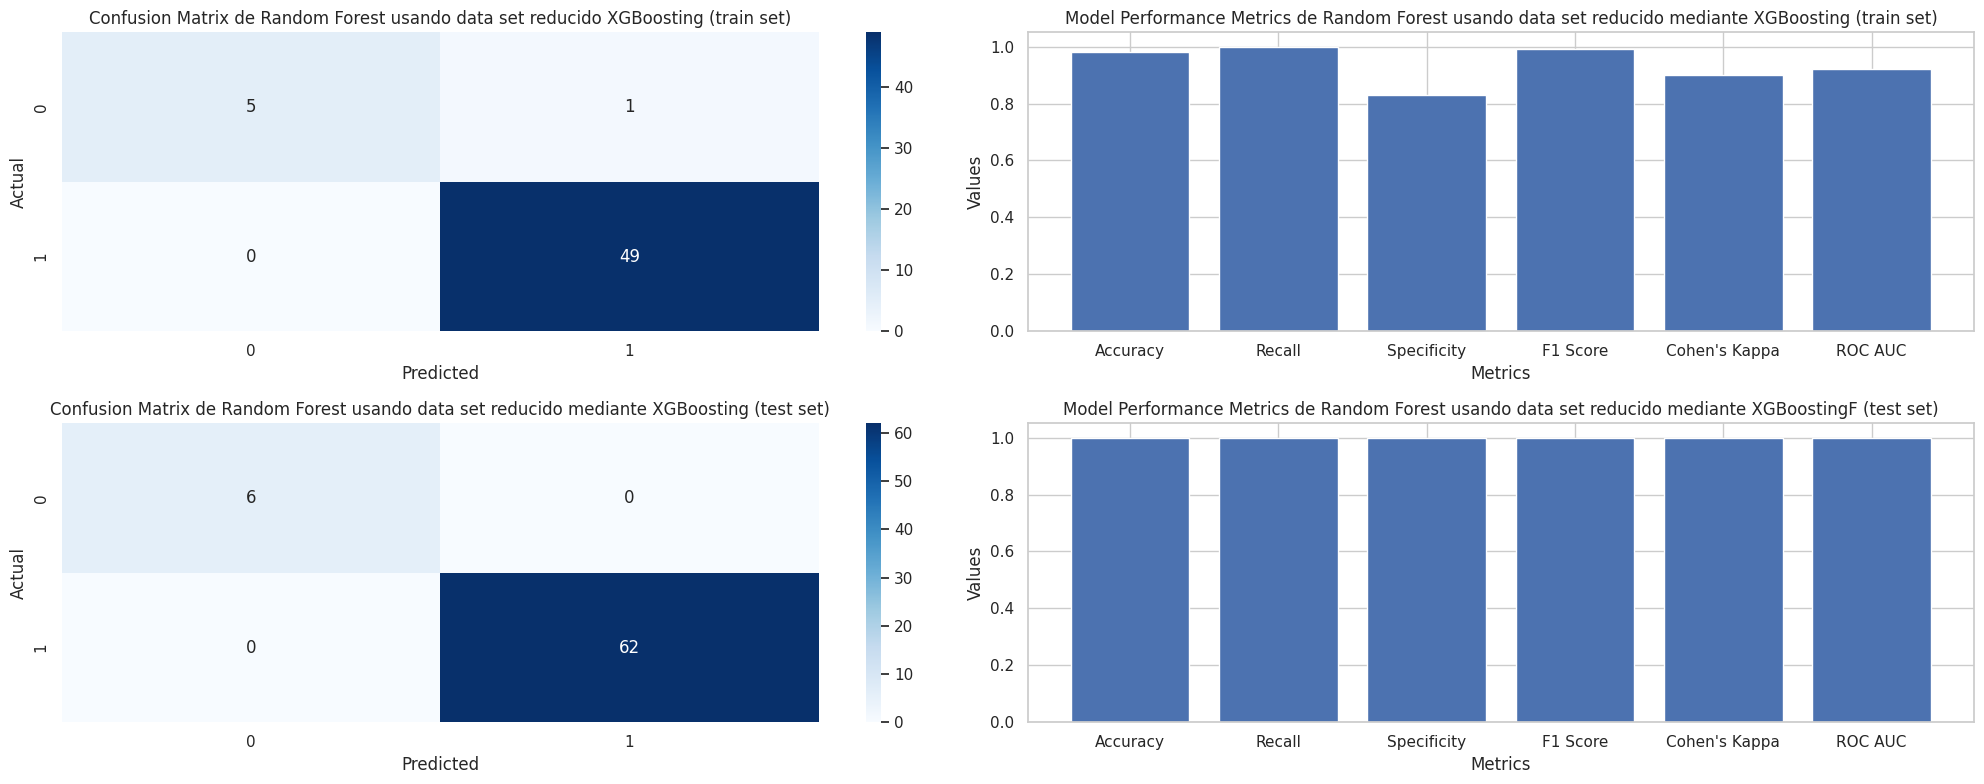

In [ ]:
# Train-test-validation split on reduced features (ANOVA + RF)
X_train0, X_test, y_train0, y_test = train_test_split(X_xgb, Y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train0, y_train0, test_size=0.2, random_state=seed)

# Performance of Random forest model on reduced features (ANOVA + RF)
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

# Matriz de confusión
confusion = confusion_matrix(y_val, y_pred)

# Establecer tamaño de la figura
plt.figure(figsize=(20, 8))

# Heat map de la matriz de confusión
plt.subplot(2, 2, 1)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de Random Forest usando data set reducido XGBoosting (train set)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_val, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_val, y_pred), 2)
roc_auc = round(roc_auc_score(y_val, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 2)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de Random Forest usando data set reducido mediante XGBoosting (train set)")

y_pred = RF.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Heat map de la matriz de confusión
plt.subplot(2, 2, 3)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de Random Forest usando data set reducido mediante XGBoosting (test set)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_test, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_test, y_pred), 2)
roc_auc = round(roc_auc_score(y_test, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 4)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de Random Forest usando data set reducido mediante XGBoostingF (test set)")

# Mostrar los gráficos
plt.tight_layout()
plt.show()

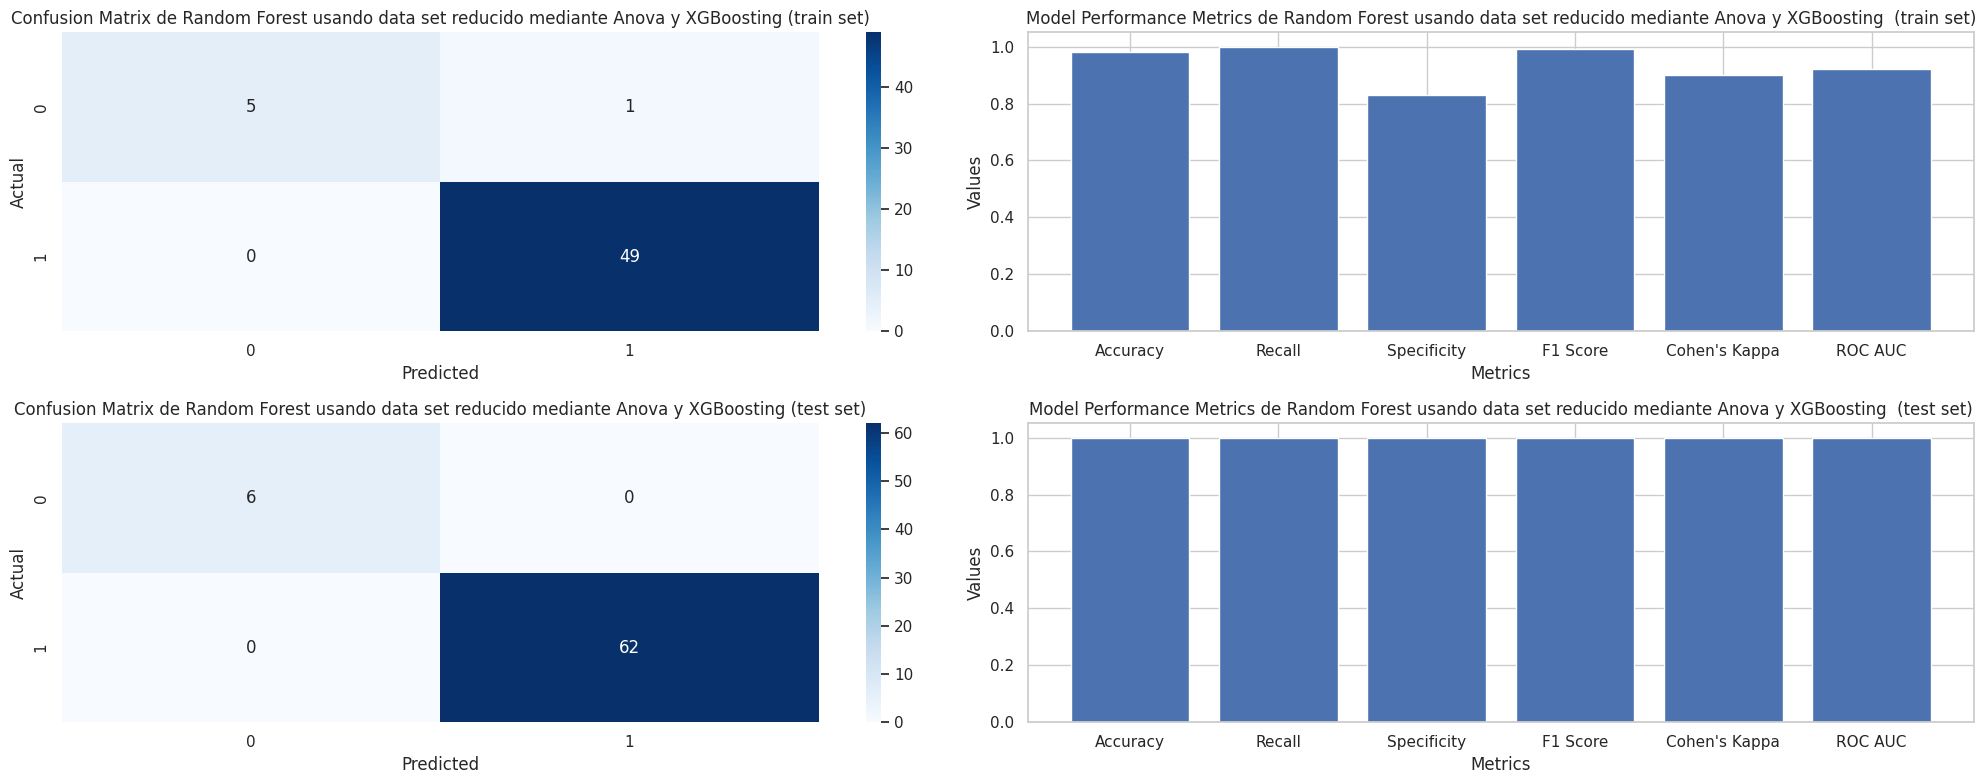

In [ ]:
# Train-test-validation split on reduced features (ANOVA + RF)
X_train0, X_test, y_train0, y_test = train_test_split(X_anova_xgb, Y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train0, y_train0, test_size=0.2, random_state=seed)

# Performance of Random forest model on reduced features (ANOVA + RF)
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

# Matriz de confusión
confusion = confusion_matrix(y_val, y_pred)

# Establecer tamaño de la figura
plt.figure(figsize=(20, 8))

# Heat map de la matriz de confusión
plt.subplot(2, 2, 1)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de Random Forest usando data set reducido mediante Anova y XGBoosting (train set)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_val, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_val, y_pred), 2)
roc_auc = round(roc_auc_score(y_val, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 2)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de Random Forest usando data set reducido mediante Anova y XGBoosting  (train set)")

y_pred = RF.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Heat map de la matriz de confusión
plt.subplot(2, 2, 3)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de Random Forest usando data set reducido mediante Anova y XGBoosting (test set)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_test, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_test, y_pred), 2)
roc_auc = round(roc_auc_score(y_test, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 4)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de Random Forest usando data set reducido mediante Anova y XGBoosting  (test set)")

# Mostrar los gráficos
plt.tight_layout()
plt.show()

## Implementación de modelo de red neuronal feedforward

Epoch: 1/50, Train Loss: 0.7497, Val Loss: 0.7347
Epoch: 2/50, Train Loss: 0.7290, Val Loss: 0.7132
Epoch: 3/50, Train Loss: 0.7055, Val Loss: 0.6902
Epoch: 4/50, Train Loss: 0.6786, Val Loss: 0.6623
Epoch: 5/50, Train Loss: 0.6443, Val Loss: 0.6297
Epoch: 6/50, Train Loss: 0.6059, Val Loss: 0.5858
Epoch: 7/50, Train Loss: 0.5554, Val Loss: 0.5252
Epoch: 8/50, Train Loss: 0.4806, Val Loss: 0.4514
Epoch: 9/50, Train Loss: 0.4016, Val Loss: 0.3691
Epoch: 10/50, Train Loss: 0.3017, Val Loss: 0.3043
Epoch: 11/50, Train Loss: 0.2545, Val Loss: 0.2806
Epoch: 12/50, Train Loss: 0.2233, Val Loss: 0.2842
Epoch: 13/50, Train Loss: 0.2098, Val Loss: 0.2874
Epoch: 14/50, Train Loss: 0.2129, Val Loss: 0.2851
Epoch: 15/50, Train Loss: 0.1952, Val Loss: 0.2756
Epoch: 16/50, Train Loss: 0.2107, Val Loss: 0.2592
Epoch: 17/50, Train Loss: 0.2008, Val Loss: 0.2491
Epoch: 18/50, Train Loss: 0.1835, Val Loss: 0.2389
Epoch: 19/50, Train Loss: 0.1645, Val Loss: 0.2320
Epoch: 20/50, Train Loss: 0.1588, Val Lo

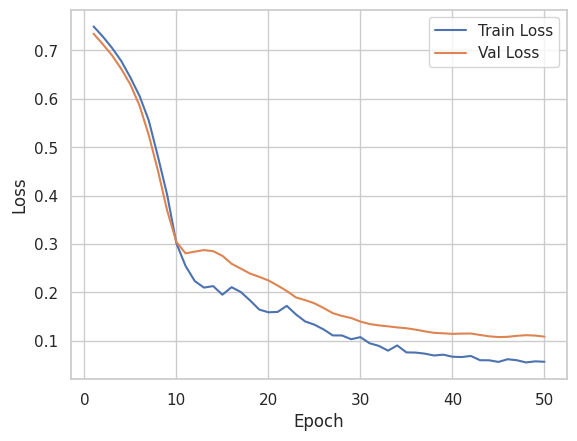

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Establecer semillas
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Definir arquitectura de la red neuronal
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden1 = nn.Linear(in_features=X_train.shape[1], out_features=10)
        self.hidden2 = nn.Linear(in_features=10, out_features=20)
        self.hidden3 = nn.Linear(in_features=20, out_features=30)
        self.hidden4 = nn.Linear(in_features=30, out_features=20)
        self.output = nn.Linear(in_features=20, out_features=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.dropout(x)
        x = self.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.relu(self.hidden3(x))
        x = self.dropout(x)
        x = self.relu(self.hidden4(x))
        x = self.dropout(x)
        x = self.output(x)
        return torch.sigmoid(x)

# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Crear conjuntos de datos y dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# Definir la red neuronal
model = NeuralNetwork()

# Definir función de pérdida y optimizador
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento de la red neuronal
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()  # Modo de entrenamiento
    train_loss = 0.0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)

    # Evaluación en el conjunto de validación
    model.eval()  # Modo de evaluación
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_dataloader.dataset)
        val_losses.append(val_loss)

    # Imprimir métricas de entrenamiento y validación en cada época
    print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Gráfico de la pérdida en función de la época
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Genes relevantes para predicción de cáncer de mama

In [ ]:
common_genes

ALX4                                            18
CHFR;CHFR;CHFR;CHFR;CHFR                        16
WT1;WT1;WT1;WT1                                 15
MGMT                                            14
GATA4                                           13
                                                ..
COX7A2;COX7A2                                    1
CTGF                                             1
KATNA1                                           1
C6orf203;C6orf203;C6orf203;C6orf203;C6orf203     1
PDXP                                             1
Name: UCSC_RefGene_Name, Length: 12901, dtype: int64

In [ ]:
nombres_genes = common_genes.index.tolist()

In [ ]:
import pandas as pd

df_genes = {}  # Crear un diccionario para almacenar los DataFrames de los genes

for gen in nombres_genes:
    sitios_cpg_gen = get_gene_cpg(features_genes, gen)
    df_gen = get_cpg_met(df_27k_tgc, sitios_cpg_gen)
    columnas_df_gen = df_gen.columns
    df_genes[gen] = df_27k_tgc.loc[:, columnas_df_gen]
    df_genes[gen] = pd.concat([df_genes[gen], df_27k_tgc[['age', 'race', 'etnia', 'tumor']]], axis=1)

# Mostrar los DataFrames de los genes
for gen, df_gen in df_genes.items():
    print(f"Gen: {gen}")
    print(df_gen)
    print("-------------------")


Se han truncado las últimas 5000 líneas del flujo de salida.
338    0.018088  50.666667         asian  not hispanic or latino      1
339    0.016395  62.028747         white  not hispanic or latino      1
340    0.015062  80.665298         asian  not hispanic or latino      1
341    0.010712  36.810404         white  not hispanic or latino      1
342    0.013268  46.666667         asian  not hispanic or latino      1

[339 rows x 5 columns]
-------------------
Gen: EPM2A;EPM2A;EPM2A;EPM2A
     cg09472953        age          race                   etnia  tumor
0      0.021130  79.326489         white  not hispanic or latino      1
1      0.020573  55.173169         white  not hispanic or latino      1
2      0.019889  69.155373         white            not reported      1
3      0.009781  54.308008         white  not hispanic or latino      1
4      0.015791  65.002053  not reported            not reported      1
..          ...        ...           ...                     ...    ...
33

In [ ]:
import pandas as pd

# Crear DataFrame vacío df_final
df_final = pd.DataFrame()

# Iterar sobre los DataFrames de los genes
for gen, df_gen in df_genes.items():
    cg_columns = [column for column in df_gen.columns if column.startswith("cg")]
    df_gen_filtered = df_gen[cg_columns]

    # Calcular mediana de columnas "cg" y agregarlo a df_final
    df_final[gen] = df_gen_filtered.median(axis=1)

# Agregar las columnas "age", "race", "etnia" y "tumor" al DataFrame df_final
df_final[["age", "race", "etnia", "tumor"]] = df_27k_tgc[["age", "race", "etnia", "tumor"]]


Se han truncado las últimas 5000 líneas del flujo de salida.
<ipython-input-214-1e43ee58e0ae>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final[gen] = df_gen_filtered.median(axis=1)
<ipython-input-214-1e43ee58e0ae>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final[gen] = df_gen_filtered.median(axis=1)
<ipython-input-214-1e43ee58e0ae>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

In [ ]:
df_final = df_final.drop(["race", "etnia"], axis=1)

In [ ]:
# Splitting data into features and target
X = df_final.iloc[:, :-1]
Y = df_final['tumor']

In [ ]:
import torch
import random
import numpy as np
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)  # Establece la semilla para generación de números aleatorios en Torch
torch.cuda.manual_seed(42)  # Establece la semilla para generación de números aleatorios en CUDA (si se utiliza GPU)
torch.backends.cudnn.deterministic = True  # Establece la determinación de los algoritmos de CUDA para mayor reproducibilidad

print("Total number of features:", X.shape[1])
a = round(0.85 * X.shape[1])
print("85% of total feature: ", a)
X_new = SelectKBest(f_classif, k=a).fit_transform(X, Y)
fvals, pvals = f_classif(X_new, Y)
to_remove = pvals >= (0.05 / X_new.shape[1])
X_anova = np.delete(X_new, obj=to_remove, axis=1)
print("Number of selected features using ANOVA F-test:", X_anova.shape[1])



Total number of features: 12902
85% of total feature:  10967
Number of selected features using ANOVA F-test: 2480


In [ ]:
sel = SelectFromModel(RandomForestClassifier())
sel.fit(X, Y)
rf_sel_features = sel.get_support()
selected_cols = np.where(rf_sel_features)[0]
X_rf = X.iloc[:, selected_cols]
print("Number of selected features using RF:", X_rf.shape[1])


Number of selected features using RF: 373


In [ ]:
sel = SelectFromModel(RandomForestClassifier())
sel.fit(X_anova, Y)
anova_rf_sel_features = sel.get_support()
selected_cols = np.where(anova_rf_sel_features)[0]
X_anova_rf = X.iloc[:, selected_cols]
print("Number of selected features using ANOVA and RF:", X_anova_rf.shape[1])

Number of selected features using ANOVA and RF: 213


In [ ]:
# Reduced features using XGBoost
sel = SelectFromModel(XGBClassifier())
sel.fit(X, Y)
xgb_sel_features = sel.get_support()
selected_cols = np.where(xgb_sel_features)[0]
X_xgb = X.iloc[:, selected_cols]
print("Number of selected features using XGBoost:", X_xgb.shape[1])

sel = SelectFromModel(XGBClassifier())
sel.fit(X_anova, Y)
anova_xgb_sel_features = sel.get_support()
selected_cols = np.where(anova_xgb_sel_features)[0]
X_anova_xgb = X.iloc[:, selected_cols]
print("Number of selected features using ANOVA and XGBoost:", X_anova_xgb.shape[1])

Number of selected features using XGBoost: 24
Number of selected features using ANOVA and XGBoost: 23


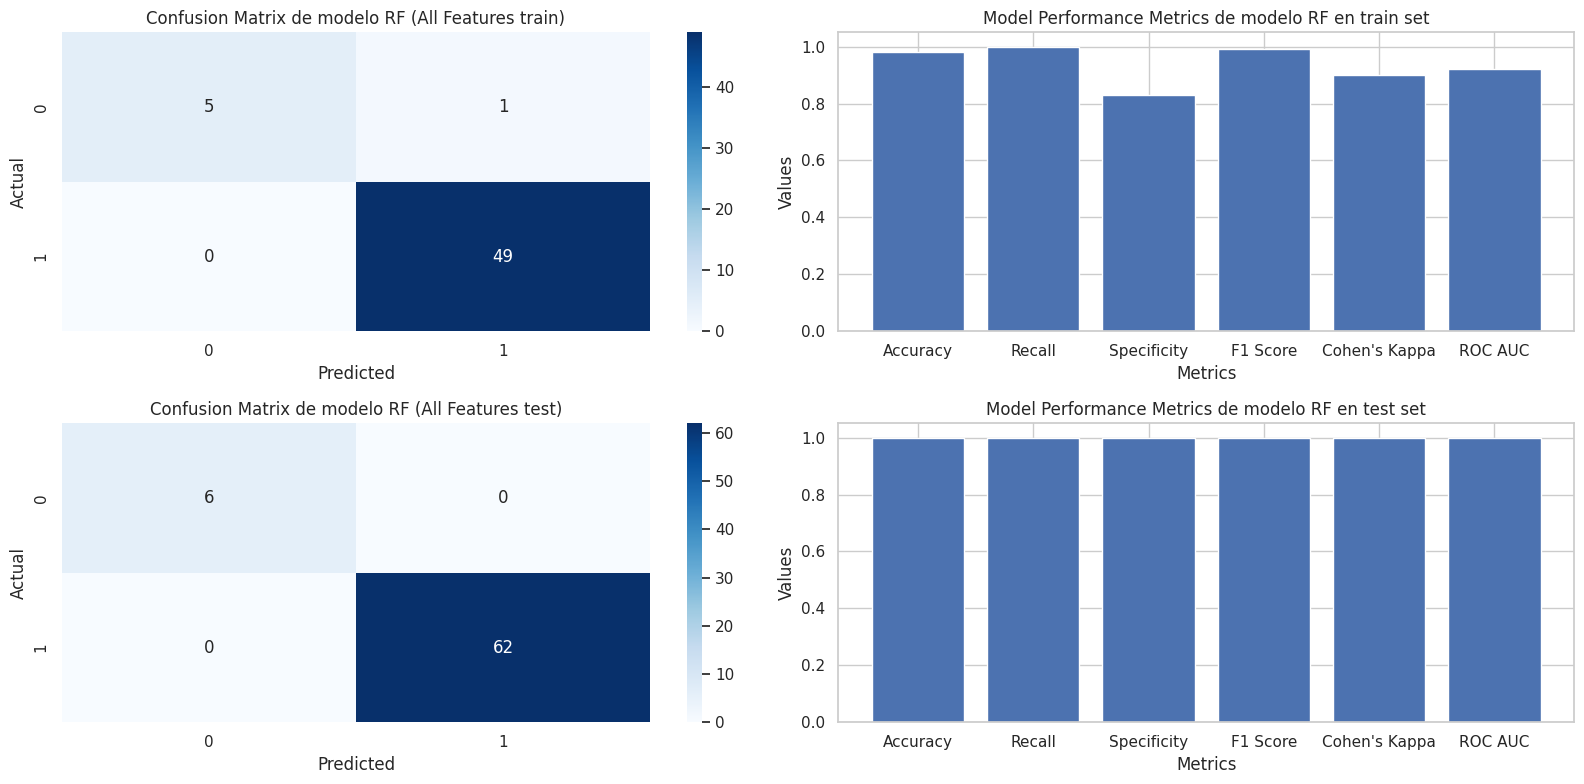

In [ ]:

# Train-test-validation split on total features (before feature selection)
X_train0, X_test, y_train0, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train0, y_train0, test_size=0.2, random_state=seed)

# Performance of Random forest model on total features
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
# Matriz de confusión
confusion = confusion_matrix(y_val, y_pred)

# Establecer tamaño de la figura
plt.figure(figsize=(16, 8))

# Heat map de la matriz de confusión
plt.subplot(2, 2, 1)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de modelo RF (All Features train)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_val, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_val, y_pred), 2)
roc_auc = round(roc_auc_score(y_val, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 2)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de modelo RF en train set")

y_pred = RF.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Heat map de la matriz de confusión
plt.subplot(2, 2, 3)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de modelo RF (All Features test)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_test, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_test, y_pred), 2)
roc_auc = round(roc_auc_score(y_test, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 4)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de modelo RF en test set")

# Mostrar los gráficos
plt.tight_layout()
plt.show()



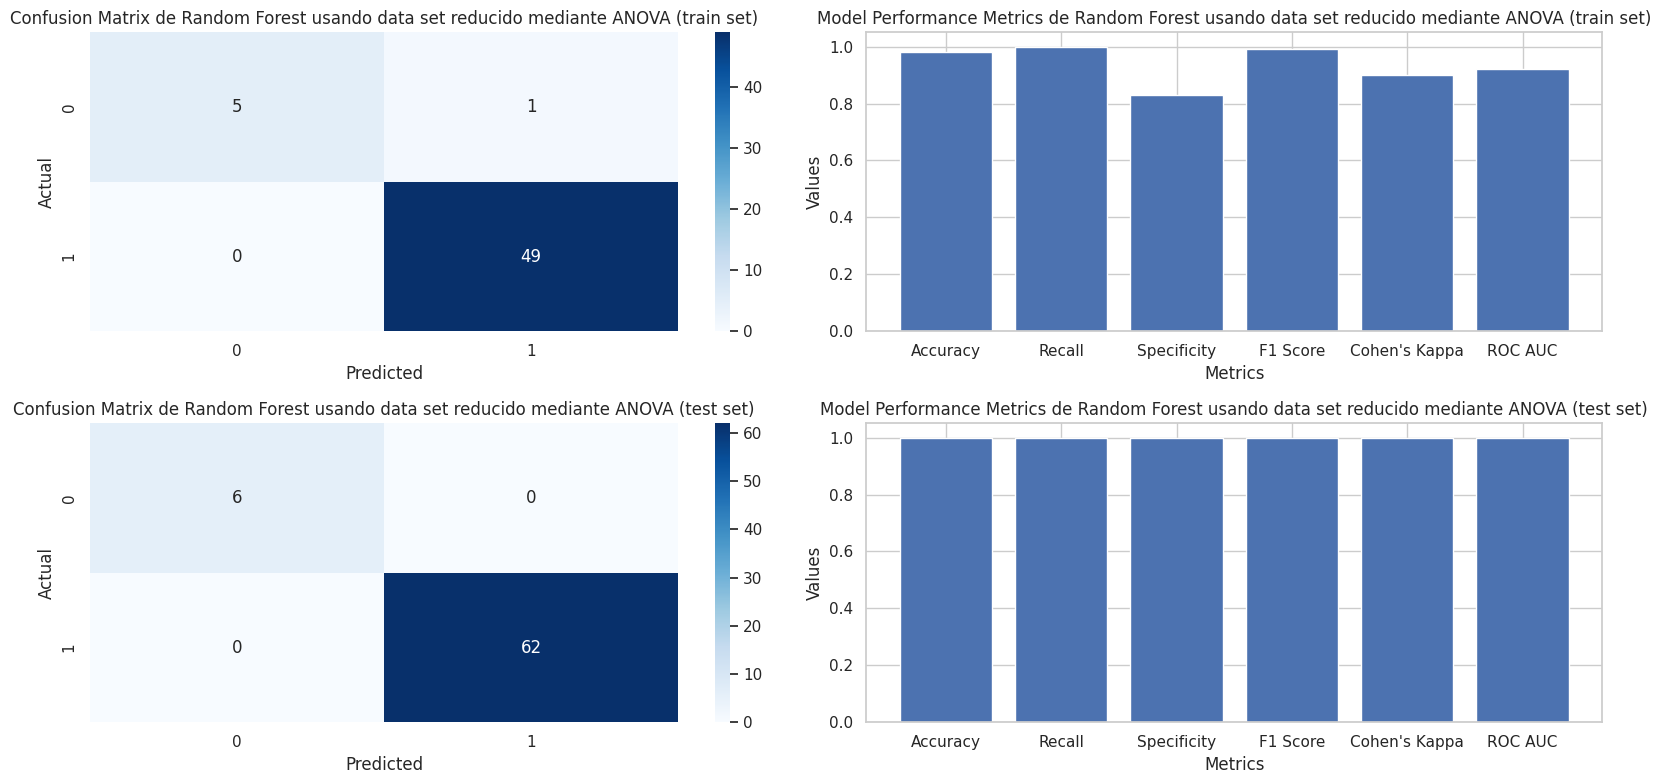

In [ ]:
# Train-test-validation split on reduced features (ANOVA)
X_train0, X_test, y_train0, y_test = train_test_split(X_anova, Y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train0, y_train0, test_size=0.2, random_state=seed)

# Performance of Random forest model on reduced features (ANOVA)
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

# Matriz de confusión
confusion = confusion_matrix(y_val, y_pred)

# Establecer tamaño de la figura
plt.figure(figsize=(16, 8))

# Heat map de la matriz de confusión
plt.subplot(2, 2, 1)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de Random Forest usando data set reducido mediante ANOVA (train set)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_val, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_val, y_pred), 2)
roc_auc = round(roc_auc_score(y_val, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 2)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de Random Forest usando data set reducido mediante ANOVA (train set)")

y_pred = RF.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Heat map de la matriz de confusión
plt.subplot(2, 2, 3)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de Random Forest usando data set reducido mediante ANOVA (test set)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_test, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_test, y_pred), 2)
roc_auc = round(roc_auc_score(y_test, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 4)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de Random Forest usando data set reducido mediante ANOVA (test set)")

# Mostrar los gráficos
plt.tight_layout()
plt.show()


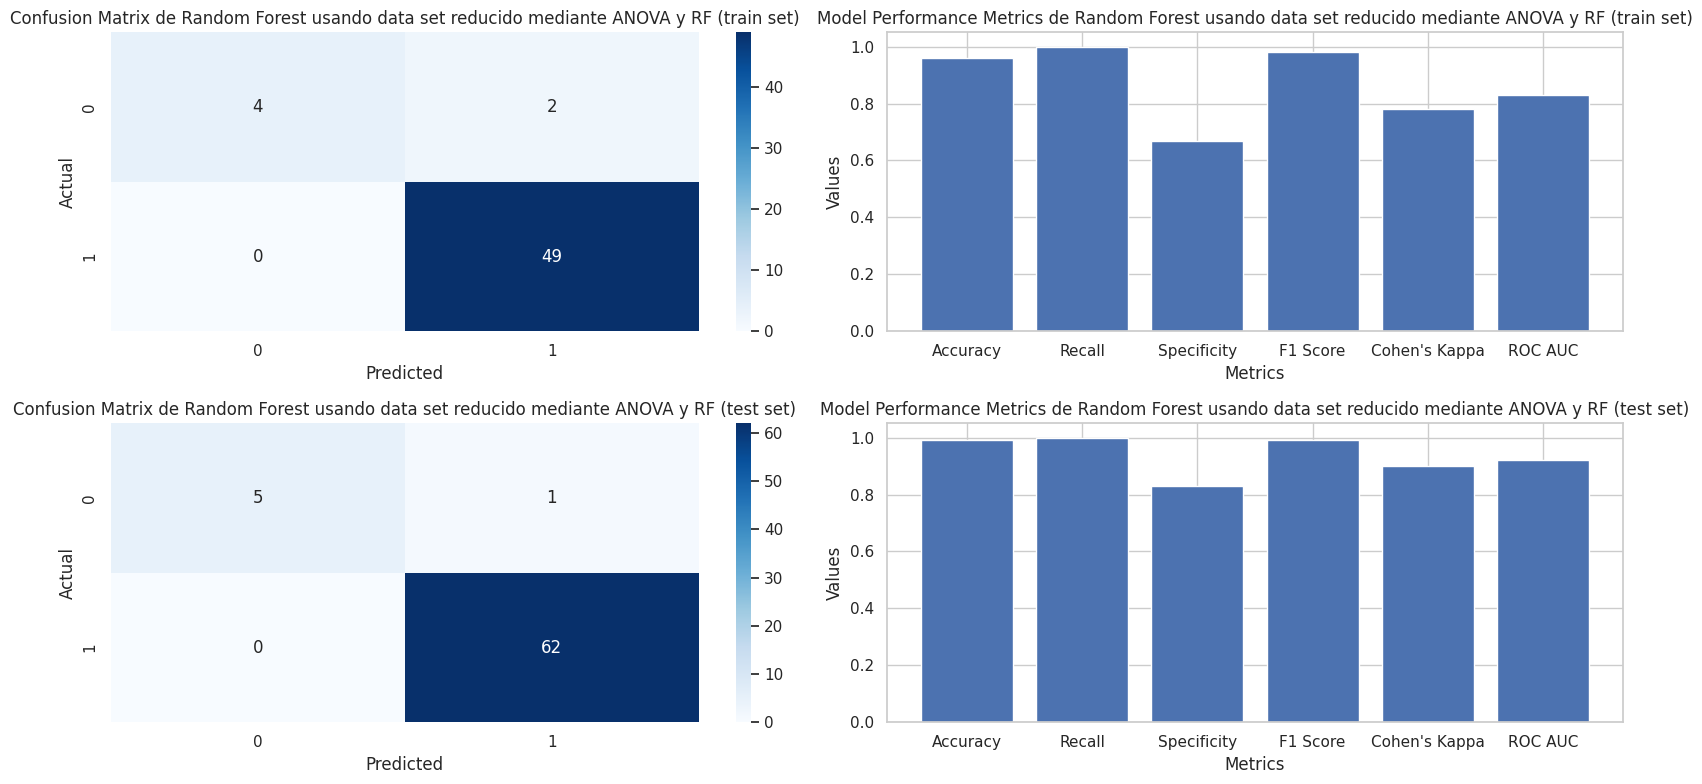

In [ ]:
# Train-test-validation split on reduced features (ANOVA + RF)
X_train0, X_test, y_train0, y_test = train_test_split(X_anova_rf, Y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train0, y_train0, test_size=0.2, random_state=seed)

# Performance of Random forest model on reduced features (ANOVA + RF)
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

# Matriz de confusión
confusion = confusion_matrix(y_val, y_pred)

# Establecer tamaño de la figura
plt.figure(figsize=(16, 8))

# Heat map de la matriz de confusión
plt.subplot(2, 2, 1)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de Random Forest usando data set reducido mediante ANOVA y RF (train set)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_val, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_val, y_pred), 2)
roc_auc = round(roc_auc_score(y_val, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 2)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de Random Forest usando data set reducido mediante ANOVA y RF (train set)")

y_pred = RF.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Heat map de la matriz de confusión
plt.subplot(2, 2, 3)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de Random Forest usando data set reducido mediante ANOVA y RF (test set)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_test, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_test, y_pred), 2)
roc_auc = round(roc_auc_score(y_test, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 4)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de Random Forest usando data set reducido mediante ANOVA y RF (test set)")

# Mostrar los gráficos
plt.tight_layout()
plt.show()

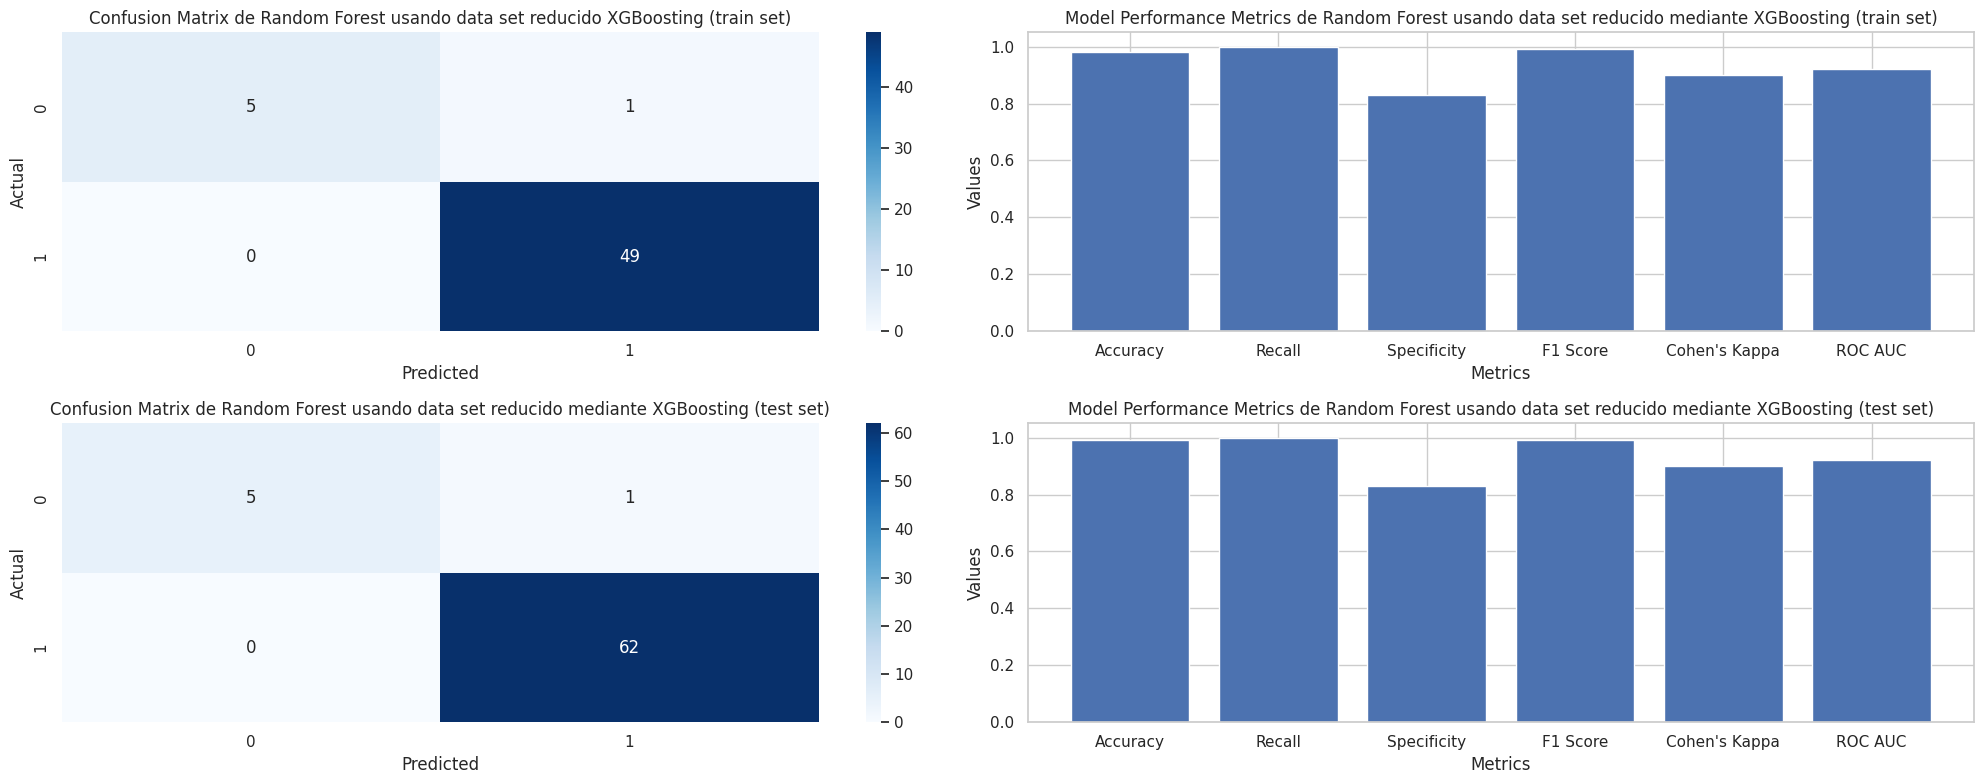

In [ ]:
# Train-test-validation split on reduced features (ANOVA + RF)
X_train0, X_test, y_train0, y_test = train_test_split(X_xgb, Y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train0, y_train0, test_size=0.2, random_state=seed)

# Performance of Random forest model on reduced features (ANOVA + RF)
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

# Matriz de confusión
confusion = confusion_matrix(y_val, y_pred)

# Establecer tamaño de la figura
plt.figure(figsize=(20, 8))

# Heat map de la matriz de confusión
plt.subplot(2, 2, 1)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de Random Forest usando data set reducido XGBoosting (train set)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_val, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_val, y_pred), 2)
roc_auc = round(roc_auc_score(y_val, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 2)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de Random Forest usando data set reducido mediante XGBoosting (train set)")

y_pred = RF.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Heat map de la matriz de confusión
plt.subplot(2, 2, 3)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de Random Forest usando data set reducido mediante XGBoosting (test set)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_test, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_test, y_pred), 2)
roc_auc = round(roc_auc_score(y_test, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 4)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de Random Forest usando data set reducido mediante XGBoosting (test set)")

# Mostrar los gráficos
plt.tight_layout()
plt.show()

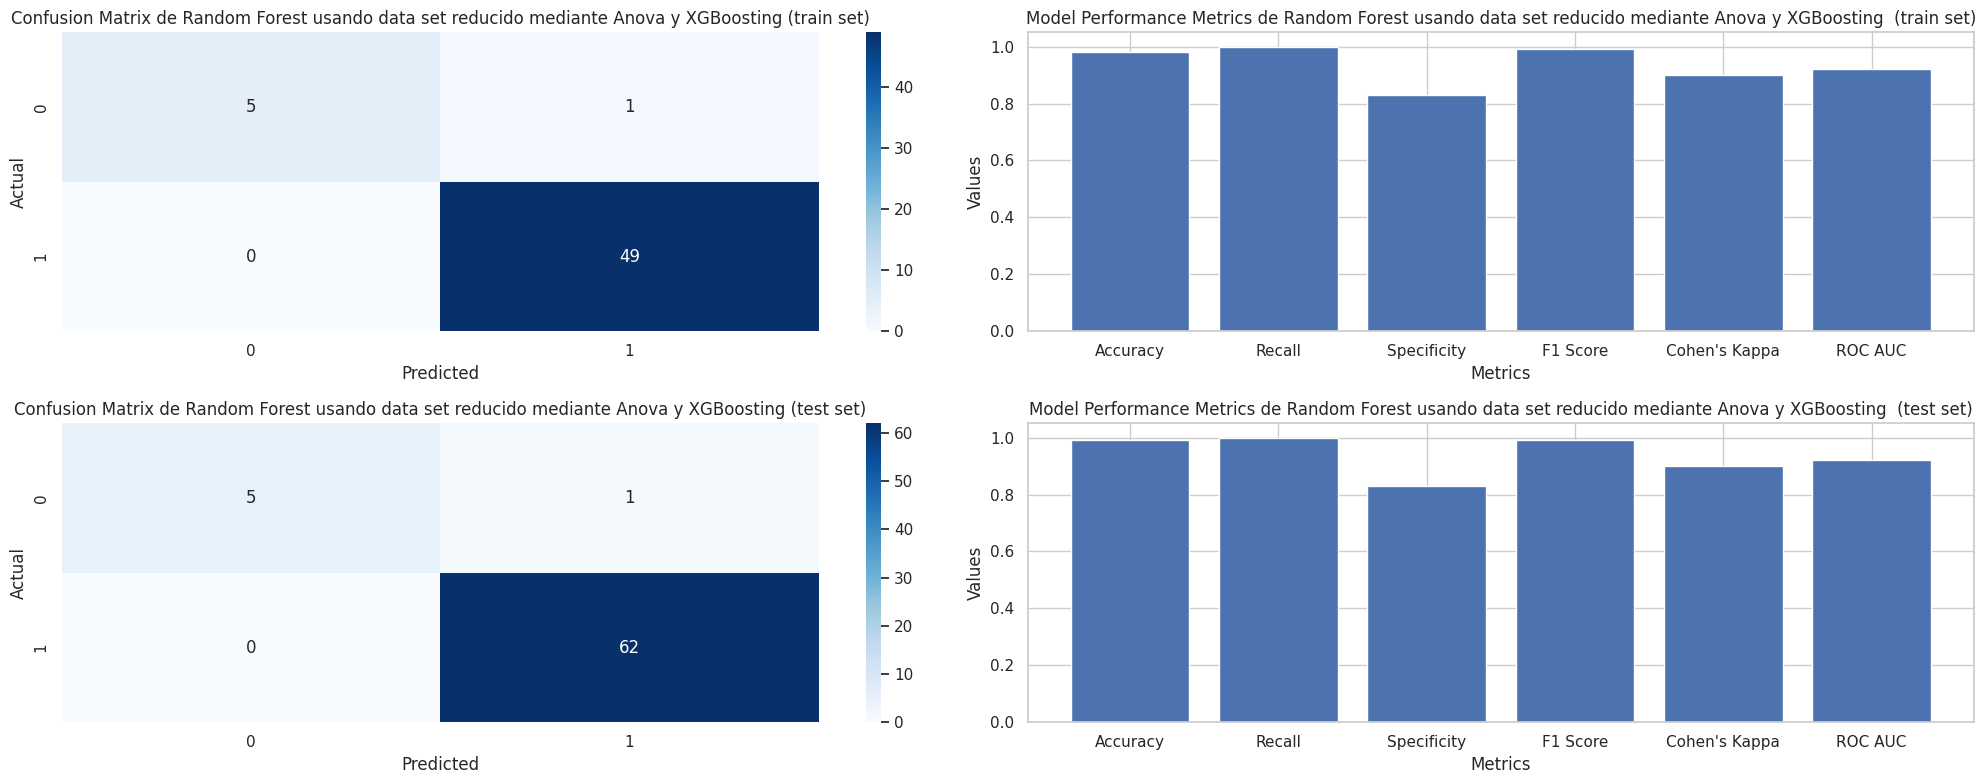

In [ ]:
# Train-test-validation split on reduced features (ANOVA + RF)
X_train0, X_test, y_train0, y_test = train_test_split(X_anova_xgb, Y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train0, y_train0, test_size=0.2, random_state=seed)

# Performance of Random forest model on reduced features (ANOVA + RF)
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

# Matriz de confusión
confusion = confusion_matrix(y_val, y_pred)

# Establecer tamaño de la figura
plt.figure(figsize=(20, 8))

# Heat map de la matriz de confusión
plt.subplot(2, 2, 1)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de Random Forest usando data set reducido mediante Anova y XGBoosting (train set)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_val, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_val, y_pred), 2)
roc_auc = round(roc_auc_score(y_val, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 2)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de Random Forest usando data set reducido mediante Anova y XGBoosting  (train set)")

y_pred = RF.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Heat map de la matriz de confusión
plt.subplot(2, 2, 3)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix de Random Forest usando data set reducido mediante Anova y XGBoosting (test set)")

# Métricas
accuracy = round((tp + tn) / (tn + fp + tp + fn), 2)
recall = round(tp / (tp + fn), 2)
specificity = round(tn / (tn + fp), 2)
f1 = round(f1_score(y_test, y_pred), 2)
cohen_kappa = round(cohen_kappa_score(y_test, y_pred), 2)
roc_auc = round(roc_auc_score(y_test, y_pred), 2)

# Crear gráfico de barras
metrics = ["Accuracy", "Recall", "Specificity", "F1 Score", "Cohen's Kappa", "ROC AUC"]
values = [accuracy, recall, specificity, f1, cohen_kappa, roc_auc]

plt.subplot(2, 2, 4)
plt.bar(metrics, values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics de Random Forest usando data set reducido mediante Anova y XGBoosting  (test set)")

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [ ]:
df_genes_relevantes = pd.concat([X_anova_xgb, Y], axis=1)
df_genes_relevantes.head(5)

,CHFR;CHFR;CHFR;CHFR;CHFR,WT1;WT1;WT1;WT1,GATA4,RBP1;RBP1;RBP1,GPR153,MIR639;TECR,SGCB,FGFBP1,HCFC1R1;HCFC1R1;HCFC1R1;THOC6;THOC6,NHEDC2;NHEDC2,...,RAB5C;RAB5C,SLC47A1,LRRC15;LRRC15,PSMD3,ZFAND5;ZFAND5;ZFAND5,TSPAN3;TSPAN3;TSPAN3,ARF6;ARF6,MYLIP,PYCRL,tumor
0,0.943474,0.120914,0.399708,0.079253,0.019912,0.016060,0.462904,0.469415,0.483529,0.037853,...,0.080309,0.045264,0.450657,0.021813,0.011908,0.477921,0.067642,0.031560,0.026091,1
1,0.877604,0.817095,0.144146,0.030842,0.018071,0.016939,0.129828,0.386230,0.401101,0.048676,...,0.127668,0.024277,0.190754,0.032965,0.013690,0.450558,0.027707,0.018334,0.046729,1
2,0.906981,0.608641,0.381444,0.275803,0.030283,0.019288,0.415184,0.474462,0.443225,0.034235,...,0.241744,0.033228,0.511865,0.024423,0.016566,0.466442,0.051938,0.016480,0.041810,1
3,0.906116,0.202788,0.322865,0.303782,0.023891,0.021086,0.373120,0.214588,0.400717,0.088754,...,0.328109,0.043694,0.106570,0.043393,0.012680,0.679416,0.054724,0.039841,0.014520,1
4,0.940790,0.793799,0.594008,0.189190,0.021573,0.019631,0.369410,0.379902,0.590772,0.041225,...,0.126073,0.064232,0.451629,0.025249,0.011824,0.468343,0.033062,0.014496,0.028759,1


Text(0, 0.5, 'Valor')

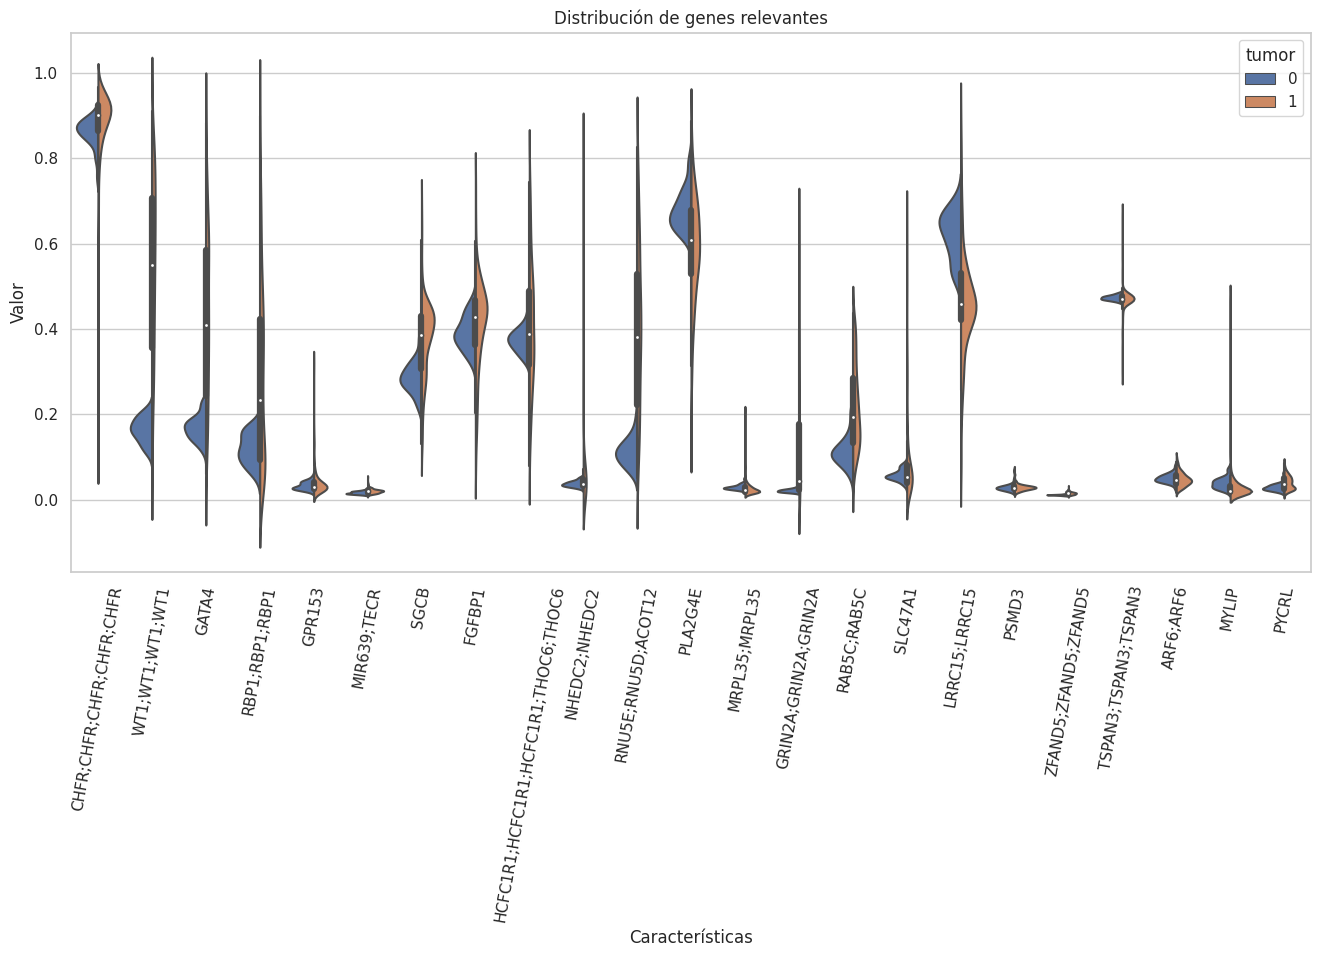

In [ ]:
# Convertir los datos al formato largo (long format) para la visualización de violín
data_melted = df_genes_relevantes.melt(id_vars='tumor', var_name='Feature', value_name='Value')

# Crear la visualización de violín utilizando seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(16,7))
sns.violinplot(x='Feature', y='Value', hue='tumor', data=data_melted, split=True)
plt.xticks(rotation=80)
plt.title("Distribución de genes relevantes")
plt.xlabel("Características")
plt.ylabel("Valor")

In [ ]:
df_genes_relevantes_head = df_genes_relevantes.iloc[300:500]
df_genes_relevantes_head

,CHFR;CHFR;CHFR;CHFR;CHFR,WT1;WT1;WT1;WT1,GATA4,RBP1;RBP1;RBP1,GPR153,MIR639;TECR,SGCB,FGFBP1,HCFC1R1;HCFC1R1;HCFC1R1;THOC6;THOC6,NHEDC2;NHEDC2,...,RAB5C;RAB5C,SLC47A1,LRRC15;LRRC15,PSMD3,ZFAND5;ZFAND5;ZFAND5,TSPAN3;TSPAN3;TSPAN3,ARF6;ARF6,MYLIP,PYCRL,tumor
304,0.854364,0.688327,0.372917,0.244841,0.021082,0.012316,0.351893,0.396860,0.157740,0.029638,...,0.129884,0.021826,0.293479,0.034086,0.019492,0.463879,0.019356,0.015535,0.016047,1
305,0.948823,0.541266,0.308650,0.106258,0.034768,0.018447,0.376477,0.375680,0.351133,0.032362,...,0.146754,0.112121,0.291428,0.027429,0.011399,0.478891,0.037651,0.022867,0.032926,1
306,0.920510,0.672221,0.566965,0.662008,0.030766,0.021680,0.452851,0.735843,0.496670,0.441098,...,0.382622,0.045246,0.505245,0.025041,0.014372,0.467220,0.046594,0.019653,0.048748,1
307,0.888299,0.727796,0.624078,0.558230,0.036828,0.037502,0.416617,0.578596,0.333623,0.029148,...,0.146356,0.030449,0.455939,0.020678,0.018975,0.438660,0.084351,0.018646,0.052027,1
308,0.878153,0.637327,0.361250,0.368504,0.029952,0.019629,0.423163,0.216957,0.480041,0.035536,...,0.246410,0.067888,0.459009,0.031571,0.015290,0.463332,0.043619,0.017738,0.050607,1
309,0.916126,0.521023,0.681383,0.107159,0.022901,0.019863,0.411094,0.315566,0.356536,0.044595,...,0.338368,0.070796,0.395702,0.020856,0.012337,0.473243,0.035734,0.020968,0.058833,1
310,0.960636,0.868466,0.763104,0.747199,0.054090,0.014579,0.434828,0.460181,0.356749,0.530502,...,0.182652,0.043719,0.447768,0.031029,0.012456,0.473117,0.030001,0.014315,0.024523,1
311,0.890374,0.656410,0.314573,0.280526,0.098545,0.021325,0.407813,0.392264,0.428374,0.030972,...,0.344668,0.061373,0.507078,0.030916,0.015079,0.470590,0.049356,0.018909,0.054952,1
312,0.896077,0.564725,0.697408,0.382576,0.028470,0.018298,0.304542,0.369158,0.470695,0.027785,...,0.381230,0.029036,0.334537,0.031197,0.020775,0.470613,0.052566,0.018246,0.053991,1
313,0.909994,0.672489,0.497326,0.105472,0.091368,0.017147,0.408920,0.267744,0.304991,0.036862,...,0.123147,0.066782,0.380014,0.017398,0.010788,0.478434,0.070930,0.030624,0.024868,1


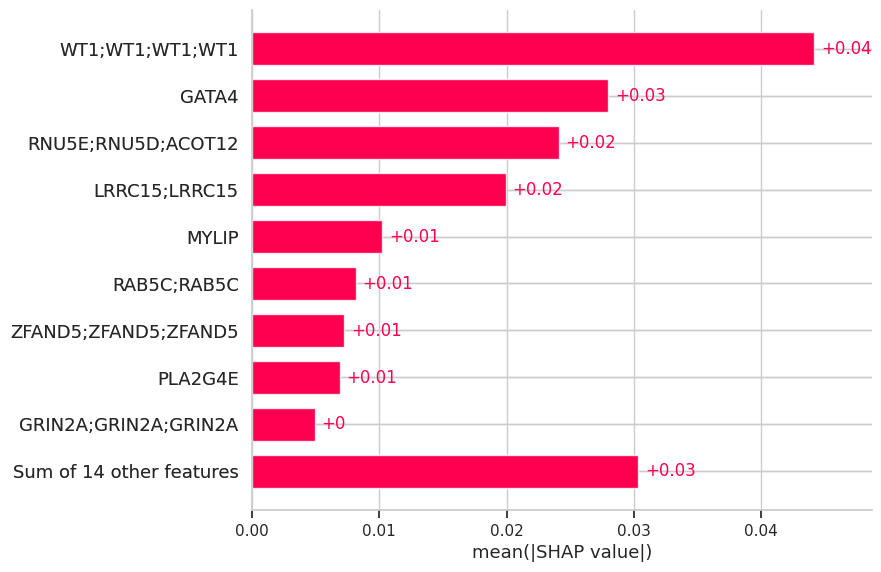

In [ ]:
import shap
import matplotlib.pyplot as plt

# Crear un explainer de SHAP con el modelo y los datos de entrada
explainer = shap.Explainer(RF, X_anova_xgb)
shap_values = explainer.shap_values(X_anova_xgb)

# Crear un objeto Explanation de SHAP
shap_explanation = shap.Explanation(values=shap_values[1], data=X_anova_xgb)
shap_explanation.feature_names = X_anova_xgb.columns
# Mostrar la gráfica de barras de los SHAP values
shap.plots.bar(shap_explanation)

# Mostrar la gráfica
plt.show()
